# The Variational Autoencoder

## 1. Introduction

### 1.1 Overview

This notebook is a code tutorial on the variational autoencoder (VAE). There are three examples. First, we learn a simple bivariate Gaussian distribution. Second, we learn a data distribution drawn from two separate bivariate Gaussians. Third, we learn to reconstruct data from the MNIST dataset. Along the way, I hope to highlight some relevant implementation details.

You should be running this notebook with a Python 3 kernel. You also need to make sure that whatever environment you're using has installed the dependencies in the imports section (numpy and torch). There is no GPU support for this code, since it should comfortably run on your personal CPU, but note that any serious attempt at modeling large models using high-dimensional data will need to contend with device management.

### 1.2 References

D. P. Kingma and M. Welling, “Auto-encoding variational bayes,” *2nd International Conference on Learning Representations, ICLR 2014*, 2014.

## 2. Main Implementation

### 2.1 Imports and Utilities

This first block is a script that autoscrolls long cells (useful for viewing training progress without needing to manually scroll down every few seconds). Source: https://stackoverflow.com/questions/41539841/automatic-scroll-down-to-bottom-of-result-in-ipython-notebook

In [5]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };

    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }

        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [7]:
import copy
from math import pi as pi
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision.datasets import MNIST as MNIST
from typing import List, Optional, Tuple

In [8]:
class MLP(nn.Module):
    """Helper class for initializing MLPs."""
    
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_layer_sizes: List[int],
        nonlinearity: nn.Module,
        dropout: Optional[float] = None,
        batchnorm: Optional[bool] = False,
    ) -> None:
        """Initialize the MLP. Activations are softpluses.

        Parameters
        ----------
        input_dim : int
            Dimension of the input.
        output_dim : int
            Dimension of the output variable.
        hidden_layer_sizes : List[int]
            List of sizes of all hidden layers.
        nonlinearity : torch.nn.Module
            A the nonlinearity to use (must be a torch module).
        dropout : float, default=None
            Dropout probability if applied.
        batchnorm : bool, default=False
            Flag for applying batchnorm. NOTE: there are a plethora of ways
            to apply batchnorm layers. I chose post-activations.
        """
        super(MLP, self).__init__()

        assert type(input_dim) == int
        assert type(output_dim) == int
        assert type(hidden_layer_sizes) == list
        assert all(type(n) is int for n in hidden_layer_sizes)

        # building MLP
        self._mlp = nn.Sequential()
        self._mlp.add_module("fc0", nn.Linear(input_dim, hidden_layer_sizes[0]))
        self._mlp.add_module("act0", nonlinearity)
        if dropout is not None and 0.0 <= dropout and dropout <= 1.0:
            self._mlp.add_module("do0", nn.Dropout(p=dropout))
        if batchnorm:
            self._mlp.add_module("bn0", nn.BatchNorm1d(hidden_layer_sizes[0]))
        for i, (in_size, out_size) in enumerate(
            zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]), 1
        ):
            self._mlp.add_module(f"fc{i}", nn.Linear(in_size, out_size))
            self._mlp.add_module(f"act{i}", nonlinearity)
            if dropout is not None and 0.0 <= dropout and dropout <= 1.0:
                self._mlp.add_module("do{i}", nn.Dropout(p=dropout))
            if batchnorm:
                self._mlp.add_module("bn{i}", nn.BatchNorm1d(out_size))
        self._mlp.add_module("fcout", nn.Linear(hidden_layer_sizes[-1], output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Parameters
        ----------
        x : torch.Tensor, shape=(..., in_dim)
            Dimension of the input.

        Returns
        -------
        mlp_out : torch.Tensor, shape=(..., out_dim)
            Output tensor.
        """
        return self._mlp(x)

SyntaxError: invalid syntax (<ipython-input-8-af4ba2ba0535>, line 6)

In [4]:
def gaussian_log_likelihood(mu: torch.Tensor, var: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """Evaluates the log likelihood of diagonal-covariance Gaussian parameters given data.
    
    Parameters
    ----------
    mu : torch.Tensor, shape=(B, X)
        Batch of means of Gaussians.
    var : torch.Tensor, shape=(B, X)
        Batch of (diagonal) covariances of Gaussians.
    x : torch.Tensor, shape=(B, X)
        Batch of data.
        
    Returns
    -------
    ll : torch.Tensor, shape=(1)
        Batch-averaged log likelihood of the parameters.
    """
    B, X = x.shape
    ll = -torch.sum(torch.sum(0.5 * (torch.log(2 * pi * var) + (x - mu) ** 2 / var), dim=-1) + X) / B
    return ll

def gaussian_dkl(
    mu_1: torch.Tensor,
    var_1: torch.Tensor,
    mu_2: torch.Tensor = None,
    var_2: torch.Tensor = None
) -> torch.Tensor:
    """Computes the analytical KL divergence between two diagonal-covariance Gaussians.
    
    Consider two Gaussian distributions D_1 = N(mu_1, var_1) and D_2 = N(mu_2, var_2).
    This function will compute D_KL(D_1 || D_2). If the parameters of D_2 are none,
    then D_2 is assumed to be the standard normal distribution.
    
    Parameters
    ----------
    mu_1 : torch.Tensor, shape=(B, X)
        Mean of D_1.
    var_1 : torch.Tensor, shape=(B, X)
        Diagonal entries of covariance of D_1.
    mu_2 : torch.Tensor, shape=(B, X), default=None
        Mean of D_2. Optional.
    var_2 : torch.Tensor, shape=(B, X), default=None
        Diagonal entries of covariance of D_2. Optional.
        
    Returns
    -------
    dkl : torch.Tensor, shape=(1)
        The batch-averged KL divergence.
    """
    B, X = mu_1.shape
    if mu_2 is None or var_2 is None:
        dkl = 0.5 * torch.sum(torch.sum(-torch.log(var_1) + var_1 + mu_1 ** 2, dim=-1) - X) / B
    else:
        dkl = 0.5 * torch.sum(
            torch.sum(torch.log(var_2) - torch.log(var_1) + (var_1 + (mu_2 - mu_1) ** 2) / var_2, dim=-1) - X
        ) / B
    return dkl

SyntaxError: invalid syntax (<ipython-input-4-825fbc02da70>, line 1)

### 2.2 VAE Code

This first VAE is for modeling some vanilla Gaussian distributions.

We choose the encoder and decoder distributions as diagonal covariance Gaussians like in the Kingma paper. The prior is fixed as the standard normal distribution. The choice of diagonal covariance Gaussians means that representing the distribution over some *n*-dimensional random variable, we simple output *2n* variables, *n* for the mean and *n* for the log-variances. We parameterize these distributions as multilayer perceptrons (MLPs).

Note that we choose our networks to output log-variances. This is because every valid (and non-degenerate) covariance matrix has strictly positive diagonal entries. We can therefore pass the outputs through an element-wise exponential to recover positive values, even if the network has negative outputs. This is an extremely common trick in learning when recovering positive values is required.

In [51]:
class VAE1(nn.Module):
    """Variational Autoencoder (VAE)."""
    
    def __init__(self, latent_dim: int, obs_dim: int) -> None:
        """Initialize a VAE for modeling continuous data.
        
        Parameters
        ----------
        latent_dim : int
            Dimension of the latent space. Denoted n in the code.
        obs_dim : int
            Dimension of the observation space. Denoted p in the code.
        """
        super(VAE1, self).__init__()
        
        # assigning dimensions
        self._latent_dim = latent_dim
        self._obs_dim = obs_dim
        
        # initializing networks
        self._encoder = MLP(
            obs_dim,
            2 * latent_dim,
            [16, 16, 16],
            nn.Softplus(beta=2),
        )
        self._decoder = MLP(
            latent_dim,
            2 * obs_dim,
            [16, 16, 16],
            nn.Softplus(beta=2),
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass of the VAE.
        
        Parameters
        ----------
        x : torch.Tensor, shape=(B, p)
            Batch of input data.
            
        Returns
        -------
        mu_e : torch.Tensor, shape=(B, n)
            Batch of means of encodings of x.
        var_e : torch.Tensor, shape=(B, n)
            Batch of (diagonal) covariances of encodings of x.
        mu_d : torch.Tensor, shape=(B, p)
            Batch of means of reconstructions of x.
        var_d : torch.Tensor, shape=(B, p)
            Batch of (diagonal) covariances of reconstructions of x.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim
        
        # encoder
        out_e = self._encoder(x)
        mu_e = out_e[..., :n]
        var_e = torch.exp(out_e[..., n:])
        
        # reparameterization
        z = self.reparameterize(mu_e, var_e)
        
        # decoder
        out_d = self._decoder(z)
        mu_d = out_d[..., :p]
        var_d = torch.exp(out_d[..., p:])
        
        return mu_e, var_e, mu_d, var_d
    
    def loss(
        self,
        x: torch.Tensor,
        mu_e: torch.Tensor,
        var_e: torch.Tensor,
        mu_d: torch.Tensor,
        var_d: torch.Tensor,
    ) -> torch.Tensor:
        """Compute the loss.
        
        Parameters
        ----------
        See docstring for forward().
        
        Returns
        -------
        loss : torch.Tensor, shape=(1)
            The VAE loss.
        """
        loss_recon = -gaussian_log_likelihood(mu_d, var_d, x)
        loss_dkl = gaussian_dkl(mu_e, var_e)
        loss = loss_recon + loss_dkl
        return loss
    
    def reparameterize(self, mu: torch.Tensor, var: torch.Tensor) -> torch.Tensor:
        """Execute the reparameterization trick.
        
        Parameters
        ----------
        mu : torch.Tensor, shape=(B, X)
            Batch of input means.
        var : torch.Tensor, shape=(B, X)
            Batch of input (diagonal) covariances.
            
        Returns
        -------
        y : torch.Tensor, shape=(B, X)
            Sample from N(mu, var)
        """
        eps = torch.randn_like(var)
        y = mu + torch.sqrt(var) * eps  # element-wise because of diagonal covariance
        return y
    
    def generate(self, num_samples: int) -> torch.Tensor:
        """Generate data.
        
        Parameters
        ----------
        num_samples : int
            Number of samples to generate.
        
        Returns
        -------
        x_gen : torch.Tensor, shape=(num_samples, p)
            Generated observations.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim

        # generation
        z_gen = torch.randn(num_samples, n)  # drawing a sample from the latent prior
        out_d = self._decoder(z_gen)  # decoding the random sample
        mu_gen = out_d[..., :p]
        var_gen = torch.exp(out_d[..., p:])
        eps = torch.randn_like(var_gen)
        x_gen = mu_gen + torch.sqrt(var_gen) * eps
        
        return x_gen

This second VAE is for modeling single-channel images (namely, for MNIST data).

The encoder functions similarly as before - it parameterizes a diagonal-covariance multivariate Gaussian. However, the decoder in this implementation does not represent a probability distribution, but is instead a *deterministic* decoder with a sigmoid final layer. Some reasons for this choice:

1) The data are not continuous, but are instead *quantized* pixel values (normalized between 0 and 1). Therefore, we need a function with an appropriate domain of [0, 1]. This also means we will use a *binary cross-entropy* loss, which works on data with values between 0 and 1.

2) The aforementioned quantization makes it harder to cleanly define a probabilistic decoder for the image sampling problem. For work on this, look up work like PixelCNN (they use quantized logistic distributions). Since the point of this tutorial is demonstrating how a VAE works, I skimped out on this detail.

Finally, it is reasonable to use convolutional neural networks instead of MLPs since we're dealing with images. MNIST data are small enough to allow MLPs to train at a not-too-slow rate.

In [52]:
class VAE2(nn.Module):
    """Variational Autoencoder (VAE)."""
    
    def __init__(self, latent_dim: int, obs_dim: int) -> None:
        """Initialize a VAE for modeling LxL single channel images.
        
        Parameters
        ----------
        latent_dim : int
            Dimension of the latent space. Denoted n in the code.
        obs_dim : int
            Dimension of the observation space. Denoted p in the code.
            NOTE: we assume the data is flattened before encoding and
            decoding will return flattened data as well.
        """
        super(VAE2, self).__init__()
        
        # assigning dimensions
        self._latent_dim = latent_dim
        self._obs_dim = obs_dim
        
        # initializing networks
        self._encoder = MLP(
            obs_dim,
            2 * latent_dim,
            [256, 128],
            nn.Softplus(beta=2),
        )
        self._decoder = nn.Sequential(
            MLP(
                latent_dim,
                obs_dim,
                [128, 256],
                nn.Softplus(beta=2),
            ),
            nn.Sigmoid(),
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass of the VAE.
        
        Parameters
        ----------
        x : torch.Tensor, shape=(B, C, sqrt(p), sqrt(p))
            Batch of input data (channel images).
            
        Returns
        -------
        mu_e : torch.Tensor, shape=(B, n)
            Batch of means of encodings of x.
        var_e : torch.Tensor, shape=(B, n)
            Batch of (diagonal) covariances of encodings of x.
        x_recon_flat : torch.Tensor, shape=(B, p)
            Batch of flattened reconstructions.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim
        
        # encoder
        out_e = self._encoder(x.reshape(-1, p))
        mu_e = out_e[..., :n]
        var_e = torch.exp(out_e[..., n:]) + 1e-6  # regularization
        
        # reparameterization
        z = self.reparameterize(mu_e, var_e)
        
        # decoder
        x_recon_flat = self._decoder(z)
        return mu_e, var_e, x_recon_flat
    
    def loss(
        self,
        x: torch.Tensor,
        x_recon_flat: torch.Tensor,
        mu_e: torch.Tensor,
        var_e: torch.Tensor,
    ) -> torch.Tensor:
        """Compute the loss.
        
        Parameters
        ----------
        See docstring for forward().
        
        Returns
        -------
        loss : torch.Tensor, shape=(1)
            The VAE loss.
        """
        B = x.shape[0]
        loss_recon = F.binary_cross_entropy(x_recon_flat, x.reshape(-1, 784), reduction='sum') / B
        loss_dkl = gaussian_dkl(mu_e, var_e)
        loss = loss_recon + loss_dkl
        return loss
    
    def reparameterize(self, mu: torch.Tensor, var: torch.Tensor) -> torch.Tensor:
        """Execute the reparameterization trick for diagonal-covariance Gaussian.
        
        Parameters
        ----------
        mu : torch.Tensor, shape=(B, X)
            Batch of input means.
        var : torch.Tensor, shape=(B, X)
            Batch of input (diagonal) covariances.
            
        Returns
        -------
        y : torch.Tensor, shape=(B, X)
            Sample from N(mu, var)
        """
        eps = torch.randn_like(var)
        y = mu + torch.sqrt(var) * eps  # element-wise because of diagonal covariance
        return y
    
    def generate(self, num_samples: int) -> torch.Tensor:
        """Generate data.
        
        Parameters
        ----------
        num_samples : int
            Number of samples to generate.
        
        Returns
        -------
        x_gen : torch.Tensor, shape=(num_samples, sqrt(p), sqrt(p))
            Generated image data of proper shape.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim
        L = int(np.sqrt(p))

        # generation
        z_gen = torch.randn(num_samples, n)  # drawing a sample from the latent prior
        x_gen_flat = self._decoder(z_gen)  # decoding the random sample
        if num_samples == 1:
            x_gen = x_gen_flat.reshape(L, L)
        else:
            x_gen = x_gen_flat.reshape(-1, L, L)
        
        return x_gen

### 2.3 Training/Evaluation Code

In [53]:
# training loop
def train(
    model: nn.Module,
    epochs: int,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[torch.optim.lr_scheduler.StepLR] = None,
    vae_type: int = 1,
    print_iter: int = 10,
    ckpt_path: str = None,
) -> Tuple[List[nn.Module], List[int]]:
    """Training loop.
    
    Parameters
    ----------
    model : nn.Module
        The model to train.
    epochs : int
        The number of training epochs.
    train_loader : torch.utils.data.DataLoader
        The data loader with training data.
    optimizer : torch.optim.Optimizer
        The optimizer.
    scheduler : Optional[torch.optim.lr_scheduler.StepLR]
        The learning rate scheduler. I suggest a step scheduler, but you can use any.
    vae_type : int, default=1
        Type of vae. Choices: {1, 2}
    print_iter : int, default=10
        Iterations between training printouts.
    ckpt_path : str, default=None
        Path to a checkpoint to load to continue training.
        
    Returns
    -------
    model_list : List[nn.Module]
        A list of snapshots of the model at each epoch of training.
    loss_list : List[int]
        A list of losses of the model at each epoch of training.
    """
    if ckpt_path is not None:
        model.load_state_dict(torch.load(ckpt_path))
        print('Loaded Checkpoint!')
    model.train()  # training mode
    
    iteration = 1
    model_list = []
    loss_list = []
    
    for epoch in range(epochs):
        for batch_idx, minibatch in enumerate(train_loader):
            optimizer.zero_grad()  # reset gradients

            # check model type
            if vae_type == 1:
                # gradient step
                mu_e, var_e, mu_d, var_d = model(minibatch)
                loss = model.loss(minibatch, mu_e, var_e, mu_d, var_d)
                
            elif vae_type == 2:
                minibatch = minibatch[0]  # tuple with label - we don't need the label
                mu_e, var_e, x_recon_flat = model(minibatch)
                loss = model.loss(minibatch, x_recon_flat, mu_e, var_e)
                
            else:
                raise NotImplementedError

            # update parameters
            loss.backward()
            optimizer.step()
                
            # printing training information every 100 iterations
            if iteration % print_iter == 0:
                print(f"Epoch: {epoch + 1}\tIteration: {iteration}\tLoss: {loss.item():.4f}")
            
            iteration = iteration + 1
            
        # advance the lr scheduler
        if scheduler is not None:
            scheduler.step()
        
        # update cached performance of the model
        model_list.append(copy.deepcopy(model))
        loss_list.append(loss.item())
    
    return model_list, loss_list

# model evaluation
def eval(
    model_list: List[nn.Module],
    loss_list: List[int],
    valid_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    vae_type: int = 1,
) -> None:
    """Evaluate the model at various stages of training.
    
    Parameters
    ----------
    See docstring of train().
    """
    epoch = 1
    for model in model_list:
        model.eval()  # set model to evaluation mode

        with torch.no_grad():
            # computing validation loss
            data = valid_loader.dataset
            
            # checking model type
            if vae_type == 1:
                # compute loss
                mu_e, var_e, mu_d, var_d = model(data)
                valid_loss = model.loss(data, mu_e, var_e, mu_d, var_d)
                print(f"Epoch {epoch} Average Validation Loss: {valid_loss.item():.4f}")

                # recovering reconstructed data samples
                eps_recon = torch.randn_like(var_d)
                x_hat = mu_d + torch.sqrt(var_d) * eps_recon
                valid_data_x = valid_loader.dataset[:, 0].numpy()
                valid_data_y = valid_loader.dataset[:, 1].numpy()

                # generating data
                num_valid_pts = valid_data_x.shape[0]
                x_gen = model.generate(num_valid_pts)

                # plotting data
                plt.scatter(valid_data_x, valid_data_y, c='r', s=5)
                plt.scatter(x_hat[:, 0], x_hat[:,1], c='b', s=5)
                plt.scatter(x_gen[:, 0], x_gen[:,1], c='g', s=5)
                plt.title(f"Data, Reconstructions, and Samples: Epoch {epoch}")

                # plot style
                plt.xlabel('x1')
                plt.ylabel('x2')
                plt.legend(
                    ['Validation Data', 'Reconstructed Data', 'Generated Data'],
                    bbox_to_anchor=(1.04,1),
                    loc="upper left",
                )
                ax = plt.gca()
                plt.axis('square')
                ax.set_aspect(1./ax.get_data_ratio())
                ax.margins(0.1)
                plt.show()
                
            elif vae_type == 2:
                valid_data = data.data.float() / 255.0  # normalizing the pixels
                
                # compute loss
                mu_e, var_e, x_recon_flat = model(valid_data)
                valid_loss = model.loss(valid_data, x_recon_flat, mu_e, var_e)
                print(f"Epoch {epoch} Average Validation Loss: {valid_loss.item():.4f}")

                example_img = valid_data.reshape(-1, 28, 28)[0]  # specific example to reconstruct
                _, _, x_recon_flat = model(example_img)
                x_recon = x_recon_flat.reshape(28, 28)
                x_gen = model.generate(1)
                
                # plots
                fig = plt.figure()
                plt.suptitle(f"Epoch {epoch}", fontsize=14)
                ax1 = fig.add_subplot(131)
                ax2 = fig.add_subplot(132)
                ax3 = fig.add_subplot(133)
                ax1.imshow(example_img.numpy(), cmap="gray")
                ax1.set_title('Validation Sample')
                ax2.imshow(x_recon.numpy(), cmap="gray")
                ax2.set_title('Reconstructed Sample')
                ax3.imshow(x_gen.numpy(), cmap="gray")
                ax3.set_title('Generated Sample')
                plt.tight_layout()
                
            else:
                raise NotImplementedError
            epoch = epoch + 1
            
    # plotting loss curve
    losses = np.array(loss_list)
    plt.figure()
    plt.plot(losses)
    plt.title("Loss Over Time")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## 3. Example 1: Learning a Multivariate Gaussian

This first example is simple: learn the distribution of data drawn from a bivariate Gaussian distribution. If you are jumping between running code in different sections, make sure to run all the code in this section from the start, since some variables are shared in the namespace.

### 3.1 Generating Data

In [54]:
# dataset statistics
obs_dim = 2
mu_data = torch.Tensor([2.0, 5.0])
cov_data = torch.Tensor(
    [[15.0, -10.0],
     [-10.0, 10.0]]
)
L_data = torch.cholesky(cov_data)

# generating training and validation sets
num_train_pts = 1000
num_valid_pts = 1000

eps_train = torch.randn(2, num_train_pts)
eps_valid = torch.randn(2, num_valid_pts)

train_data_ex1 = mu_data + (L_data @ eps_train).transpose(-1, -2)
valid_data_ex1 = mu_data + (L_data @ eps_valid).transpose(-1, -2)

### 3.2 Training Settings

You should play around with the settings in this section. I choose the ADAM optimizer and a step learning scheduler, so the hyperparameters will correspondingly only be appropriate for those choices. As is convention, the reparameterization trick is coded to produce only one sample, so this is not a tunable hyperparameter.

In [55]:
# hyperparameters
latent_dim = 2
batch_size = 32
epochs = 100
lr = 1e-2  # initial learning ratex_mean = vae_2d.generate(z_mu)
step_size = 50  # steps per decay for lr scheduler
gamma = 0.9  # multiplicative decay for lr scheduler

Don't mess with the code in this section unless you want to change the optimizer or LR scheduler.

In [56]:
# preparing dataloaders, optimizer, and scheduler
model_ex1 = VAE1(latent_dim, obs_dim)
train_loader_ex1 = torch.utils.data.DataLoader(
    train_data_ex1,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
valid_loader_ex1 = torch.utils.data.DataLoader(
    valid_data_ex1,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
optimizer_ex1 = optim.Adam(model_ex1.parameters(), lr=lr)
scheduler_ex1 = optim.lr_scheduler.StepLR(optimizer=optimizer_ex1, step_size=step_size, gamma=gamma)

### 3.3 Training

Run this cell to train the model.

In [57]:
model_list_ex1, loss_list_ex1 = train(
    model_ex1,
    epochs,
    train_loader_ex1,
    optimizer_ex1,
    scheduler=scheduler_ex1
)

Epoch: 1	Iteration: 10	Loss: 11.8811
Epoch: 1	Iteration: 20	Loss: 7.9938
Epoch: 1	Iteration: 30	Loss: 8.0323
Epoch: 2	Iteration: 40	Loss: 7.1329
Epoch: 2	Iteration: 50	Loss: 7.6557
Epoch: 2	Iteration: 60	Loss: 7.9112
Epoch: 3	Iteration: 70	Loss: 7.4532
Epoch: 3	Iteration: 80	Loss: 7.4685
Epoch: 3	Iteration: 90	Loss: 7.6007
Epoch: 4	Iteration: 100	Loss: 7.0428
Epoch: 4	Iteration: 110	Loss: 7.7316
Epoch: 4	Iteration: 120	Loss: 7.2039
Epoch: 5	Iteration: 130	Loss: 7.2074
Epoch: 5	Iteration: 140	Loss: 7.2533
Epoch: 5	Iteration: 150	Loss: 7.2579
Epoch: 6	Iteration: 160	Loss: 6.8653
Epoch: 6	Iteration: 170	Loss: 7.6131
Epoch: 6	Iteration: 180	Loss: 7.3974
Epoch: 7	Iteration: 190	Loss: 7.3082
Epoch: 7	Iteration: 200	Loss: 7.5107
Epoch: 7	Iteration: 210	Loss: 7.4173
Epoch: 8	Iteration: 220	Loss: 7.2205
Epoch: 8	Iteration: 230	Loss: 7.1705
Epoch: 8	Iteration: 240	Loss: 7.4678
Epoch: 9	Iteration: 250	Loss: 6.8965
Epoch: 9	Iteration: 260	Loss: 7.1669
Epoch: 9	Iteration: 270	Loss: 7.4380
Epoch: 10

Epoch: 71	Iteration: 2200	Loss: 6.7074
Epoch: 72	Iteration: 2210	Loss: 6.6762
Epoch: 72	Iteration: 2220	Loss: 6.6167
Epoch: 72	Iteration: 2230	Loss: 6.9728
Epoch: 73	Iteration: 2240	Loss: 6.9408
Epoch: 73	Iteration: 2250	Loss: 6.7613
Epoch: 73	Iteration: 2260	Loss: 6.8734
Epoch: 74	Iteration: 2270	Loss: 6.8670
Epoch: 74	Iteration: 2280	Loss: 6.7466
Epoch: 74	Iteration: 2290	Loss: 6.6414
Epoch: 75	Iteration: 2300	Loss: 6.2848
Epoch: 75	Iteration: 2310	Loss: 6.3887
Epoch: 75	Iteration: 2320	Loss: 7.1779
Epoch: 76	Iteration: 2330	Loss: 6.6370
Epoch: 76	Iteration: 2340	Loss: 6.9531
Epoch: 76	Iteration: 2350	Loss: 6.7702
Epoch: 77	Iteration: 2360	Loss: 6.4663
Epoch: 77	Iteration: 2370	Loss: 7.0153
Epoch: 77	Iteration: 2380	Loss: 6.4149
Epoch: 78	Iteration: 2390	Loss: 6.9096
Epoch: 78	Iteration: 2400	Loss: 6.7637
Epoch: 78	Iteration: 2410	Loss: 7.0328
Epoch: 79	Iteration: 2420	Loss: 6.8018
Epoch: 79	Iteration: 2430	Loss: 6.8648
Epoch: 79	Iteration: 2440	Loss: 6.7436
Epoch: 80	Iteration: 2450

### 3.4 Evaluation

Run this code to evaluate the model and see the progress it made during training. The reconstructed samples show the ability of the VAE to autoencode: to recreate the data once given. The generated samples show the ability of the VAE to generate samples: to reproduce the data distribution without seeing the validation data. You may need to uncheck "Auto-Scroll-To-Bottom" to scroll up and see earlier plots.

Epoch 1 Average Validation Loss: 7.8110


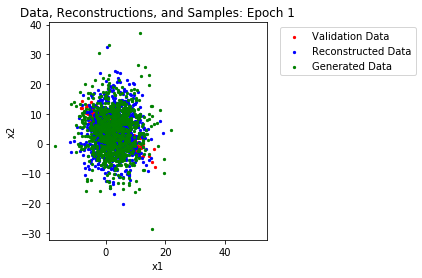

Epoch 2 Average Validation Loss: 7.4169


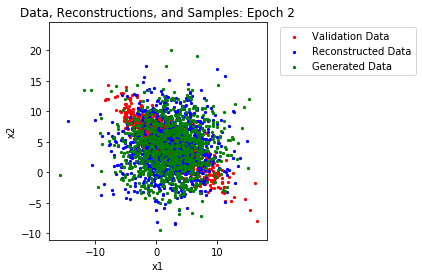

Epoch 3 Average Validation Loss: 7.3548


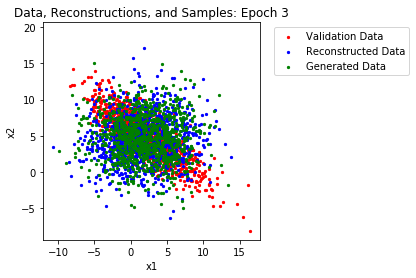

Epoch 4 Average Validation Loss: 7.3562


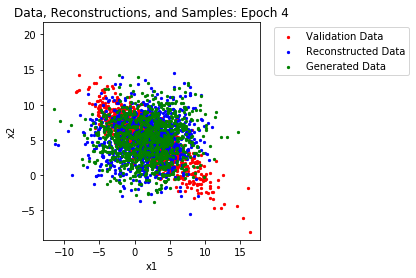

Epoch 5 Average Validation Loss: 7.3520


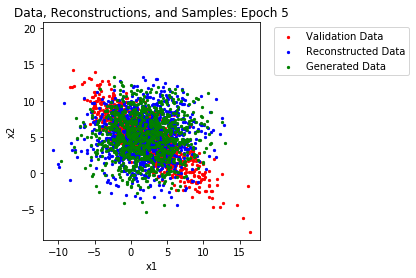

Epoch 6 Average Validation Loss: 7.3567


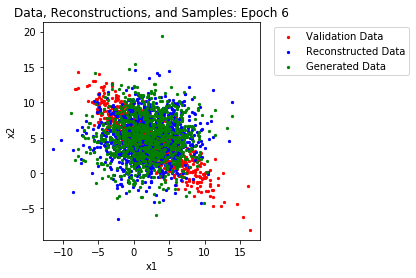

Epoch 7 Average Validation Loss: 7.3460


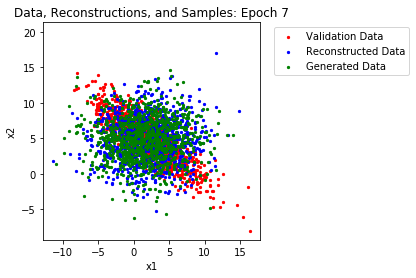

Epoch 8 Average Validation Loss: 7.3760


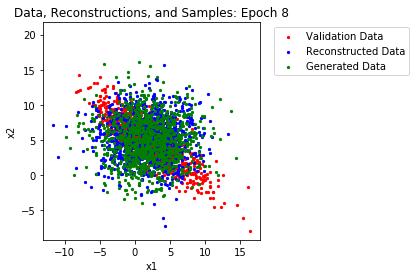

Epoch 9 Average Validation Loss: 7.3734


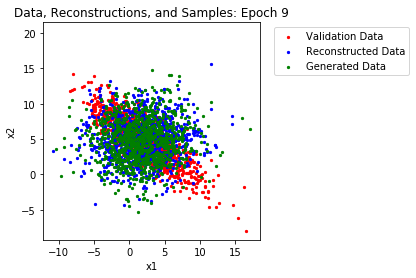

Epoch 10 Average Validation Loss: 7.3507


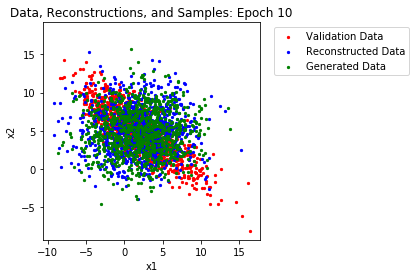

Epoch 11 Average Validation Loss: 7.3543


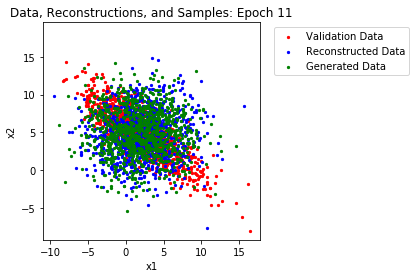

Epoch 12 Average Validation Loss: 7.3571


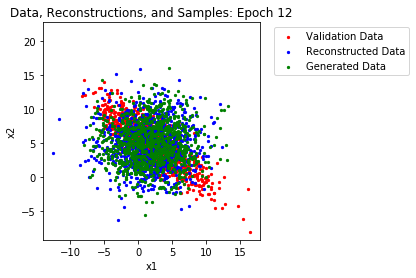

Epoch 13 Average Validation Loss: 7.3574


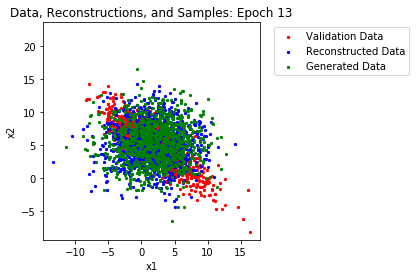

Epoch 14 Average Validation Loss: 7.3538


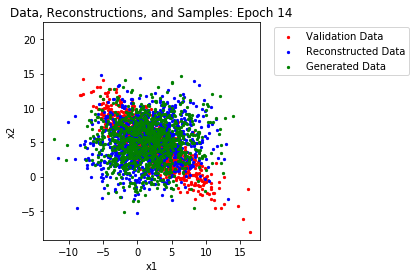

Epoch 15 Average Validation Loss: 7.3535


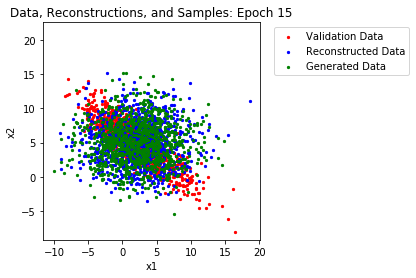

Epoch 16 Average Validation Loss: 7.3606


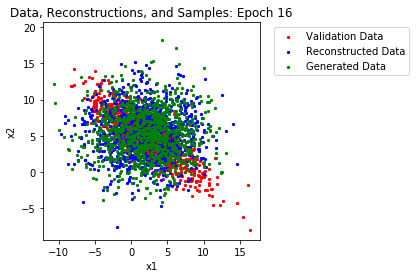

Epoch 17 Average Validation Loss: 7.3605


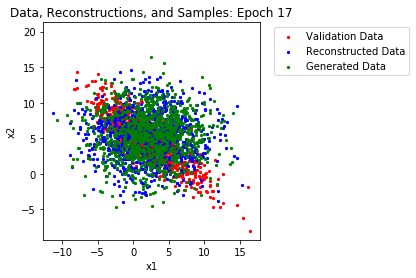

Epoch 18 Average Validation Loss: 7.3581


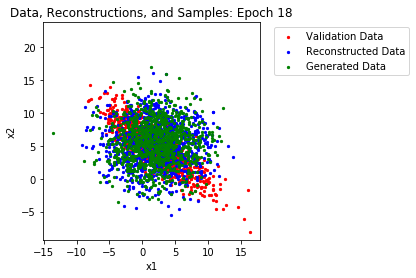

Epoch 19 Average Validation Loss: 7.3533


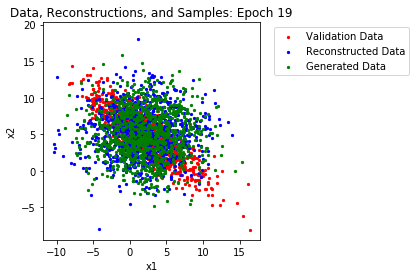

Epoch 20 Average Validation Loss: 7.3510


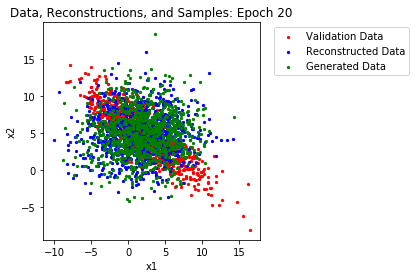

Epoch 21 Average Validation Loss: 7.3519


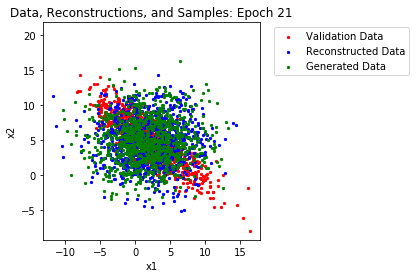

Epoch 22 Average Validation Loss: 7.3595


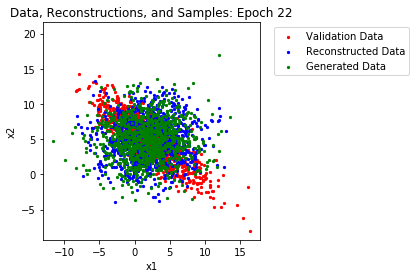

Epoch 23 Average Validation Loss: 7.3674


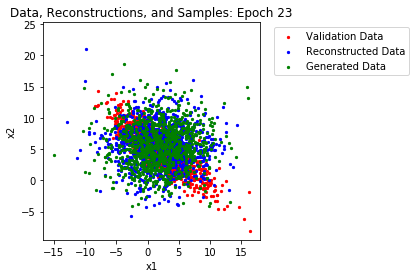

Epoch 24 Average Validation Loss: 7.3332


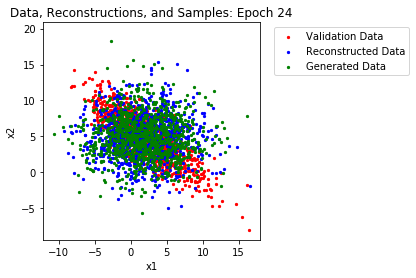

Epoch 25 Average Validation Loss: 7.3690


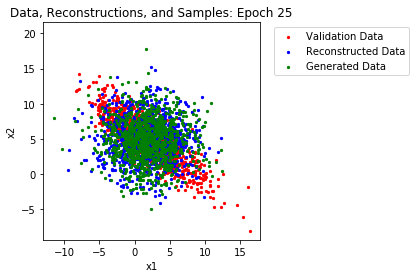

Epoch 26 Average Validation Loss: 7.3639


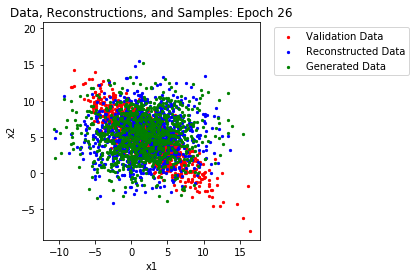

Epoch 27 Average Validation Loss: 7.3547


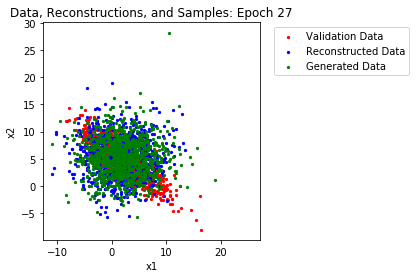

Epoch 28 Average Validation Loss: 7.3562


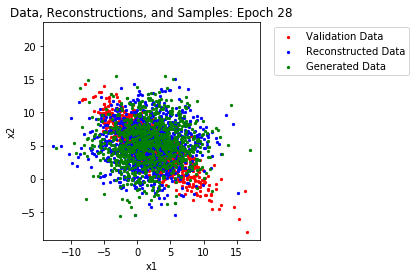

Epoch 29 Average Validation Loss: 7.3654


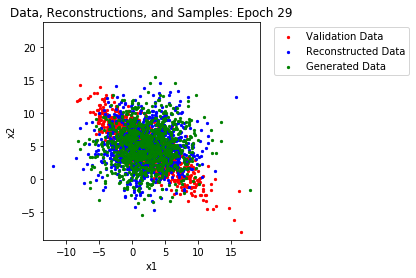

Epoch 30 Average Validation Loss: 7.3755


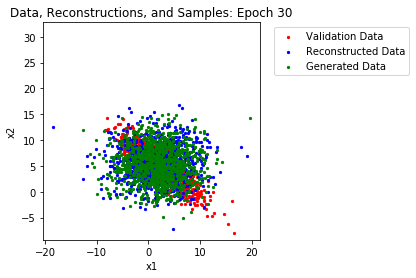

Epoch 31 Average Validation Loss: 7.3509


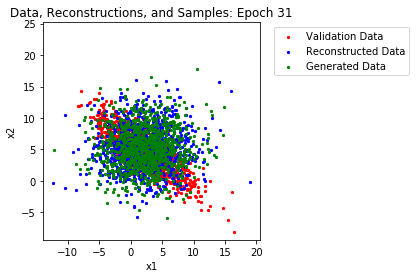

Epoch 32 Average Validation Loss: 7.3946


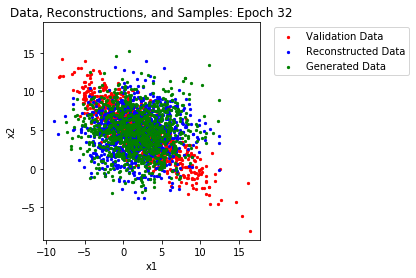

Epoch 33 Average Validation Loss: 7.3367


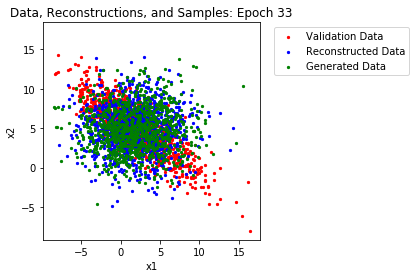

Epoch 34 Average Validation Loss: 7.3682


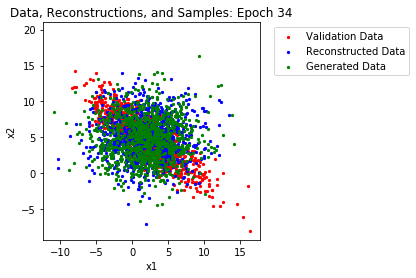

Epoch 35 Average Validation Loss: 7.3353


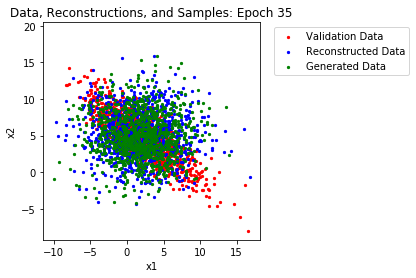

Epoch 36 Average Validation Loss: 7.3507


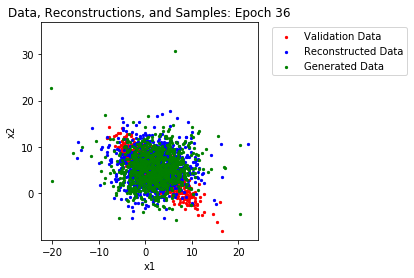

Epoch 37 Average Validation Loss: 7.3620


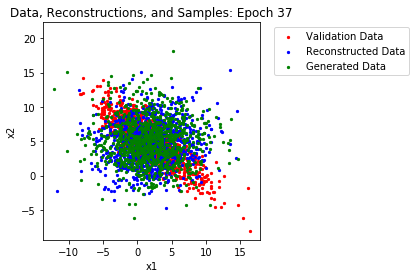

Epoch 38 Average Validation Loss: 7.3501


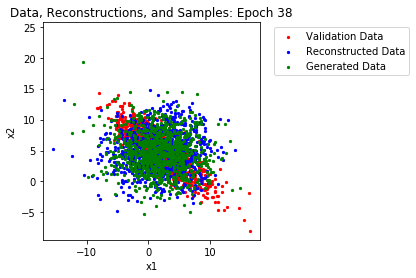

Epoch 39 Average Validation Loss: 7.3493


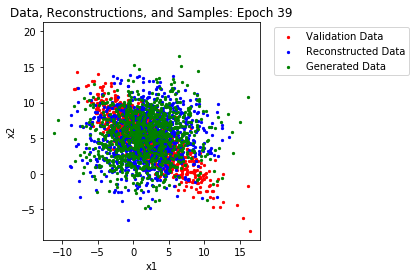

Epoch 40 Average Validation Loss: 7.3446


Epoch 41 Average Validation Loss: 7.3507


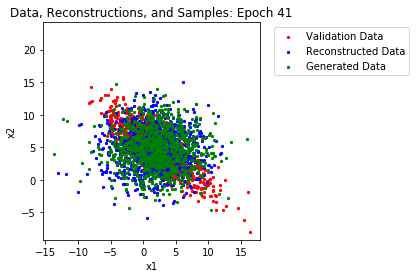

Epoch 42 Average Validation Loss: 7.3540


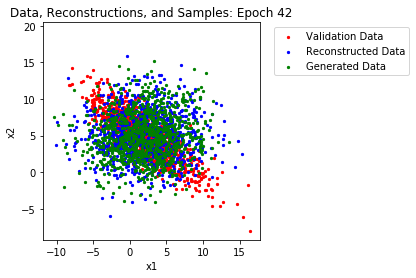

Epoch 43 Average Validation Loss: 7.3508


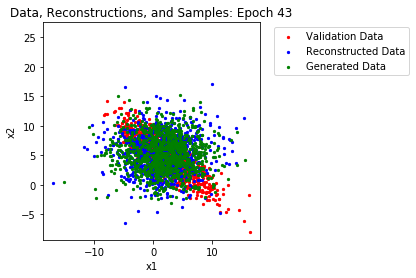

Epoch 44 Average Validation Loss: 7.3330


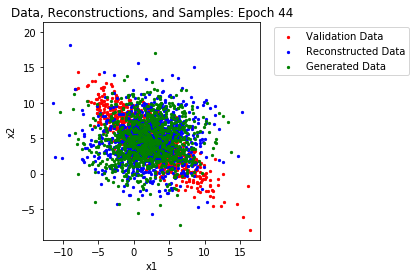

Epoch 45 Average Validation Loss: 7.3500


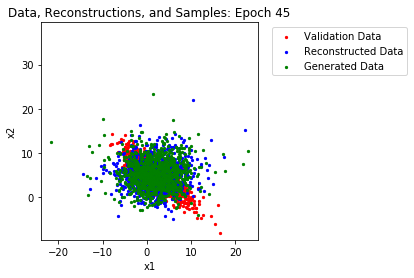

Epoch 46 Average Validation Loss: 7.3727


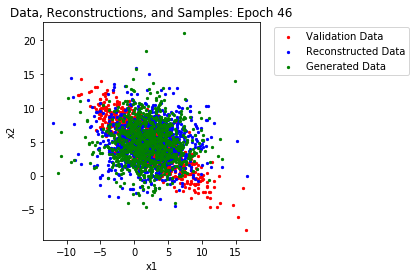

Epoch 47 Average Validation Loss: 7.3639


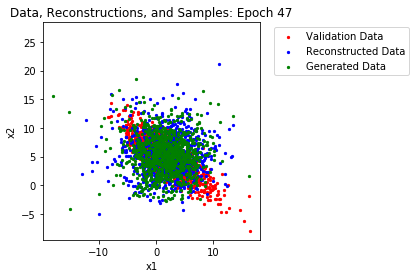

Epoch 48 Average Validation Loss: 7.3169


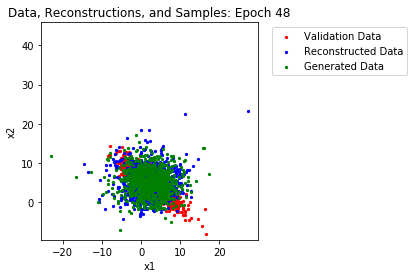

Epoch 49 Average Validation Loss: 7.3339


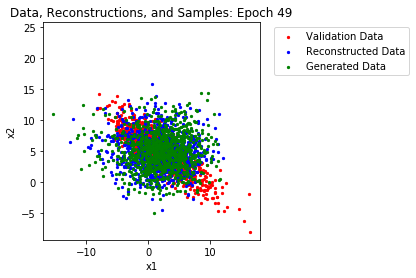

Epoch 50 Average Validation Loss: 7.3101


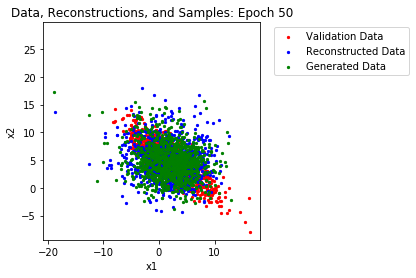

Epoch 51 Average Validation Loss: 7.1735


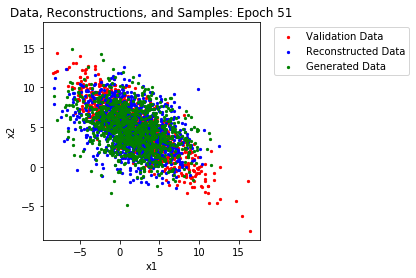

Epoch 52 Average Validation Loss: 6.9843


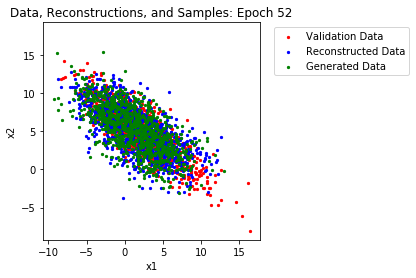

Epoch 53 Average Validation Loss: 6.9748


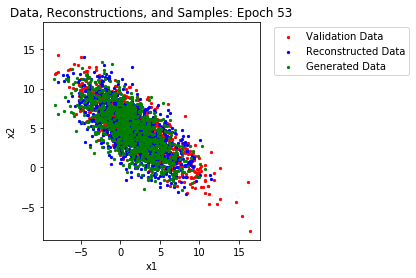

Epoch 54 Average Validation Loss: 6.8744


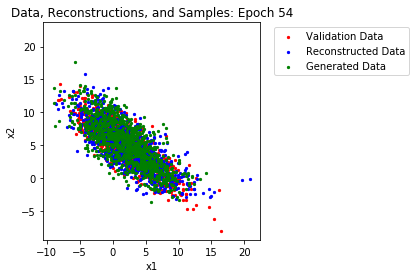

Epoch 55 Average Validation Loss: 6.9672


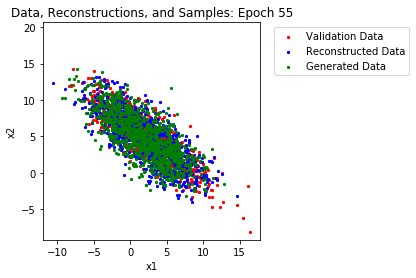

Epoch 56 Average Validation Loss: 6.8108


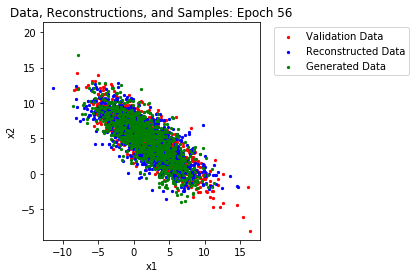

Epoch 57 Average Validation Loss: 6.9034


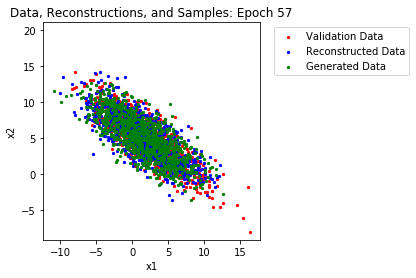

Epoch 58 Average Validation Loss: 6.8987


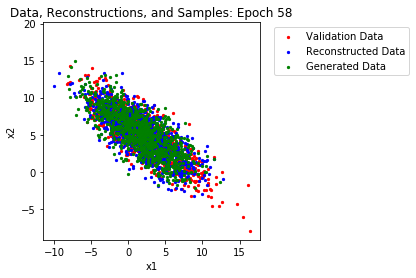

Epoch 59 Average Validation Loss: 6.9418


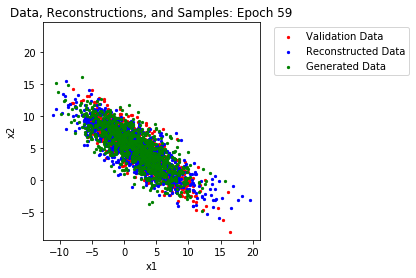

Epoch 60 Average Validation Loss: 6.7984


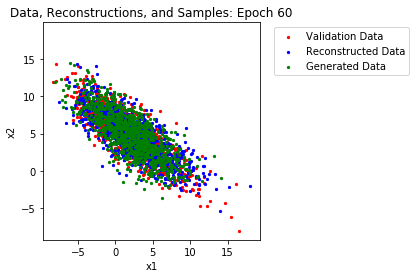

Epoch 61 Average Validation Loss: 6.8877


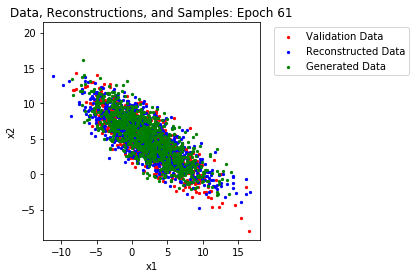

Epoch 62 Average Validation Loss: 6.9105


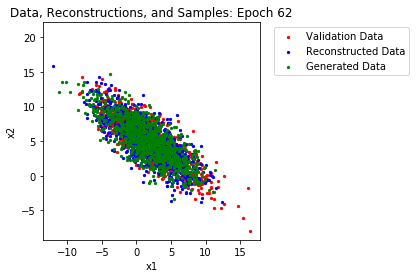

Epoch 63 Average Validation Loss: 6.7947


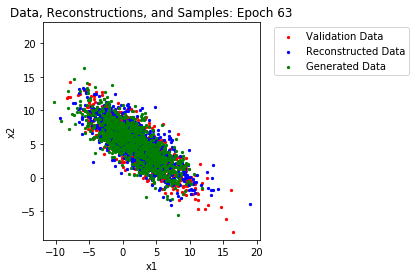

Epoch 64 Average Validation Loss: 6.8375


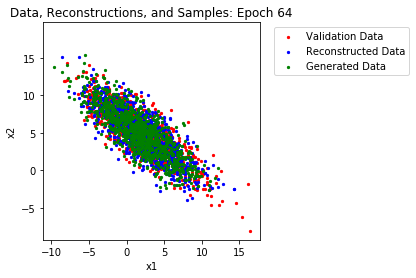

Epoch 65 Average Validation Loss: 6.7928


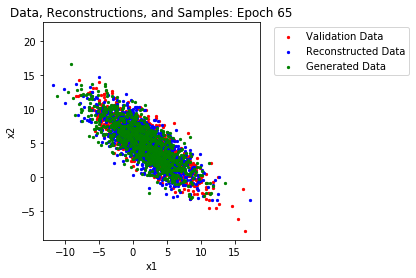

Epoch 66 Average Validation Loss: 6.8809


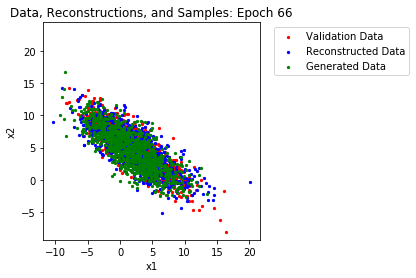

Epoch 67 Average Validation Loss: 6.8883


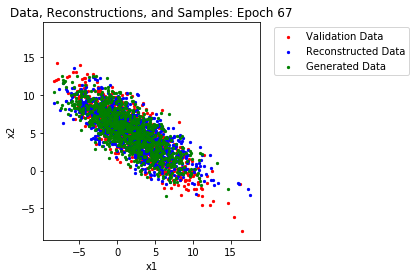

Epoch 68 Average Validation Loss: 6.8067


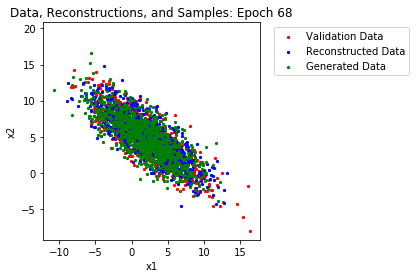

Epoch 69 Average Validation Loss: 6.8878


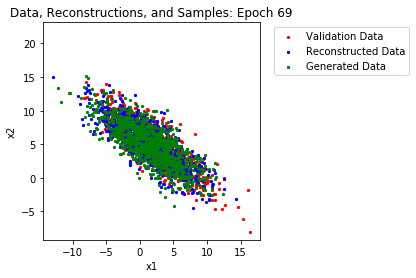

Epoch 70 Average Validation Loss: 6.7987


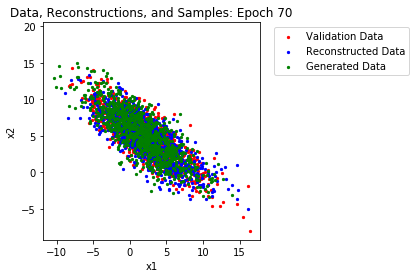

Epoch 71 Average Validation Loss: 6.8656


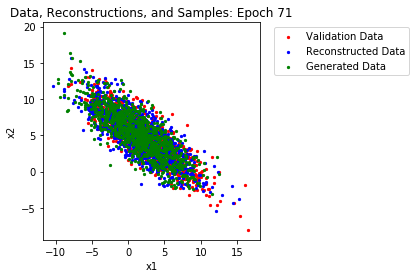

Epoch 72 Average Validation Loss: 6.8340


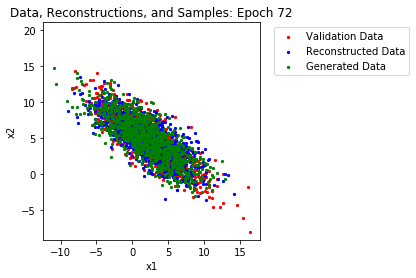

Epoch 73 Average Validation Loss: 6.8668


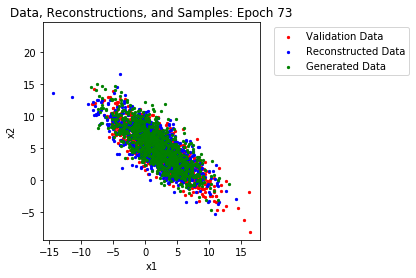

Epoch 74 Average Validation Loss: 6.7767


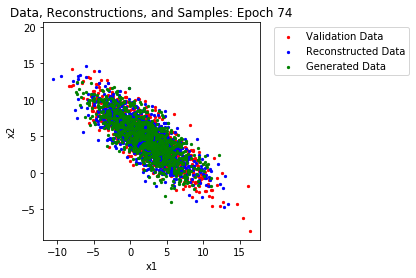

Epoch 75 Average Validation Loss: 6.8113


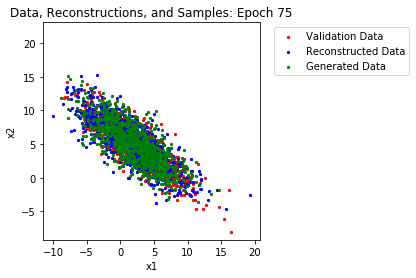

Epoch 76 Average Validation Loss: 6.7703


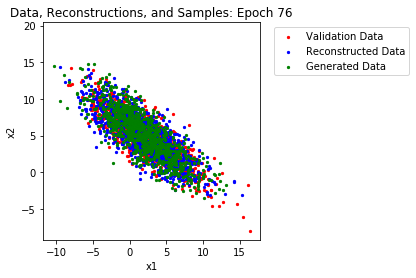

Epoch 77 Average Validation Loss: 6.8423


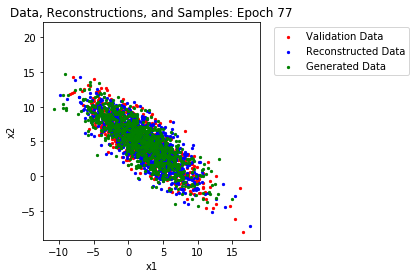

Epoch 78 Average Validation Loss: 6.8291


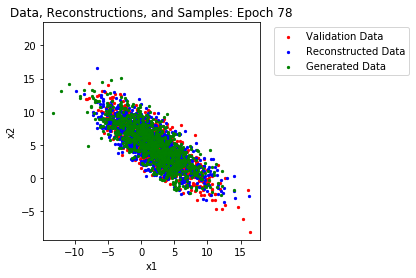

Epoch 79 Average Validation Loss: 6.8419


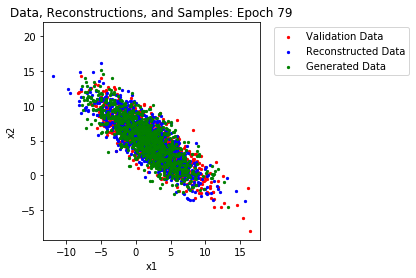

Epoch 80 Average Validation Loss: 6.8274


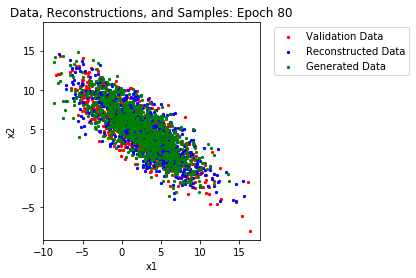

Epoch 81 Average Validation Loss: 6.8471


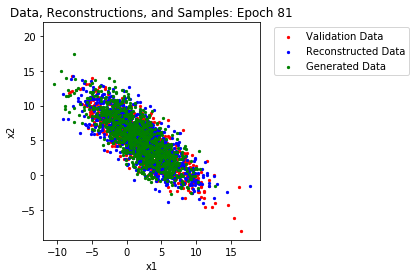

Epoch 82 Average Validation Loss: 6.8058


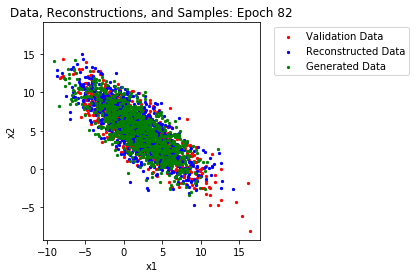

Epoch 83 Average Validation Loss: 6.7892


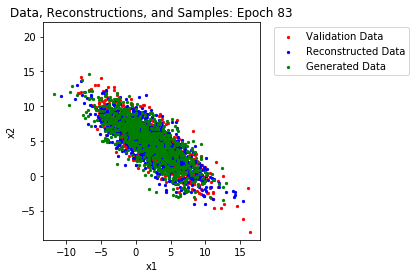

Epoch 84 Average Validation Loss: 6.7942


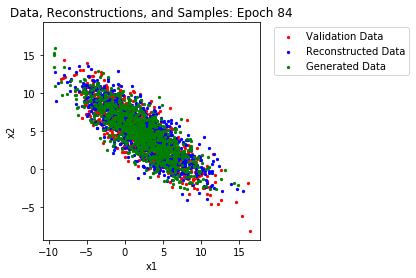

Epoch 85 Average Validation Loss: 6.9490


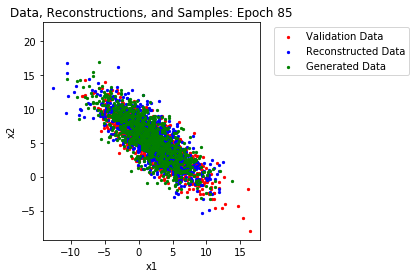

Epoch 86 Average Validation Loss: 6.7854


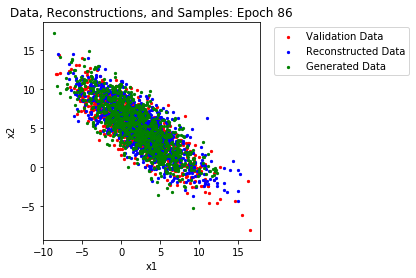

Epoch 87 Average Validation Loss: 6.7823


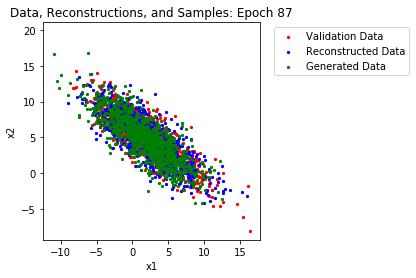

Epoch 88 Average Validation Loss: 6.7894


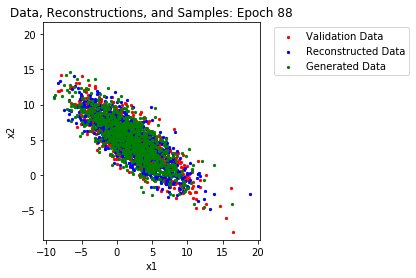

Epoch 89 Average Validation Loss: 6.8217


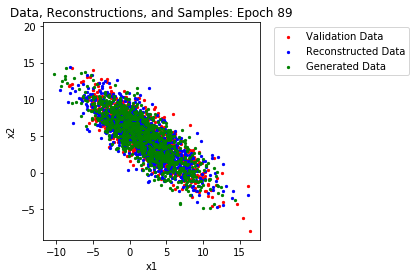

Epoch 90 Average Validation Loss: 6.8450


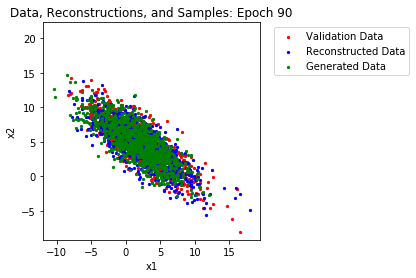

Epoch 91 Average Validation Loss: 6.8534


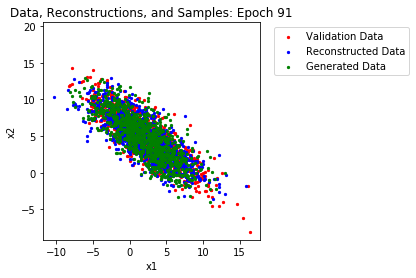

Epoch 92 Average Validation Loss: 6.8442


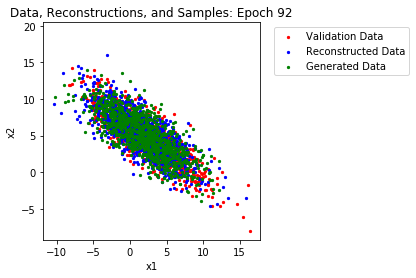

Epoch 93 Average Validation Loss: 6.8227


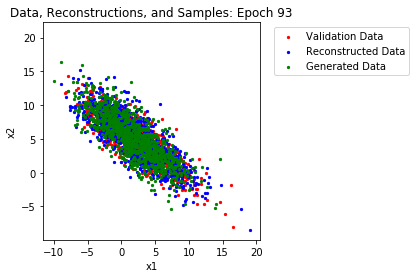

Epoch 94 Average Validation Loss: 6.9084


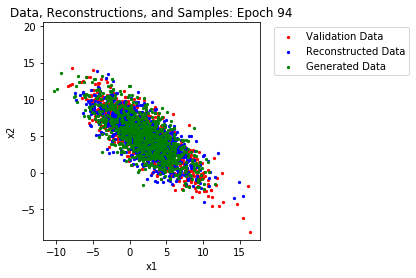

Epoch 95 Average Validation Loss: 6.7695


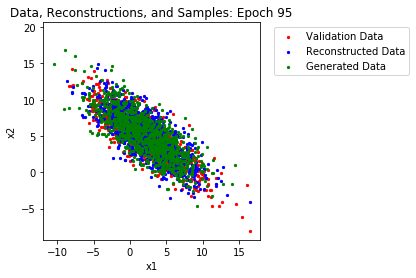

Epoch 96 Average Validation Loss: 6.8683


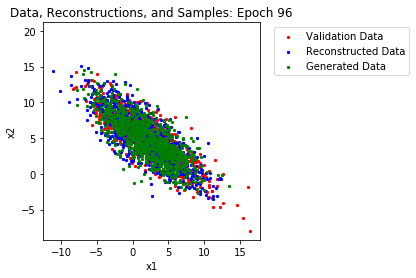

Epoch 97 Average Validation Loss: 6.8017


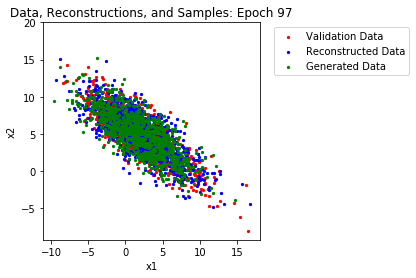

Epoch 98 Average Validation Loss: 6.8304


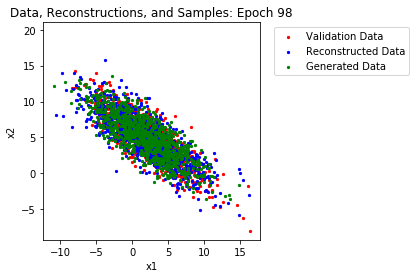

Epoch 99 Average Validation Loss: 6.8316


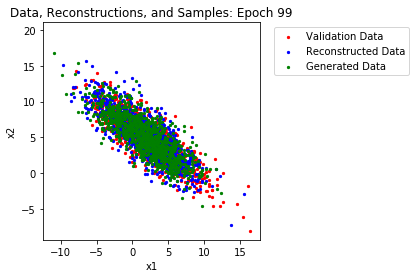

Epoch 100 Average Validation Loss: 6.8299


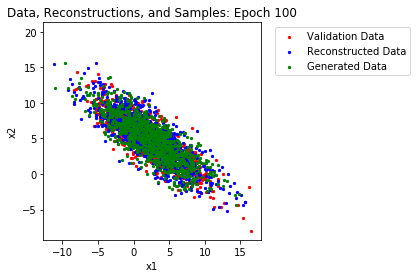

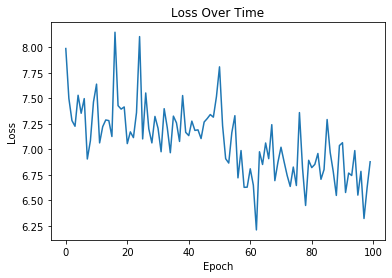

In [58]:
eval(model_list_ex1, loss_list_ex1, valid_loader_ex1, optimizer_ex1)

## 4. Example 2: Learning Two Multivariate Gaussians

The previous example was fairly trivial. Let's see if we can take it further and learn a data distribution which is composed of two independent modes, each a multivariate Gaussian.

### 4.1 Generating Data

In [60]:
# dataset statistics
obs_dim = 2
mu_data_1 = torch.Tensor([2.0, 5.0])
cov_data_1 = torch.Tensor(
    [[15.0, -10.0],
     [-10.0, 10.0]]
)
L_data_1 = torch.cholesky(cov_data_1)

mu_data_2 = torch.Tensor([18.0, 20.0])
cov_data_2 = torch.Tensor(
    [[5.0, -3.0],
     [-3.0, 20.0]]
)
L_data_2 = torch.cholesky(cov_data_2)

# generating training and validation sets
num_train_pts = 10000
num_valid_pts = 1000

eps_train_1 = torch.randn(2, num_train_pts // 2)
eps_train_2 = torch.randn(2, num_train_pts // 2)
eps_valid_1 = torch.randn(2, num_valid_pts // 2)
eps_valid_2 = torch.randn(2, num_valid_pts // 2)

train_data_1 = mu_data_1 + (L_data_1 @ eps_train_1).transpose(-1, -2)
train_data_2 = mu_data_2 + (L_data_2 @ eps_train_2).transpose(-1, -2)
valid_data_1 = mu_data_1 + (L_data_1 @ eps_valid_1).transpose(-1, -2)
valid_data_2 = mu_data_2 + (L_data_2 @ eps_valid_2).transpose(-1, -2)

train_data_ex2 = torch.cat([train_data_1, train_data_2], dim=0)
valid_data_ex2 = torch.cat([valid_data_1, valid_data_2], dim=0)

### 4.2 Training Settings

In [61]:
# hyperparameters
latent_dim = 2
batch_size = 32
epochs = 100
lr = 1e-3  # initial learning rate
step_size = 10  # steps per decay for lr scheduler
gamma = 0.9  # multiplicative decay for lr scheduler

In [62]:
# preparing dataloaders, optimizer, and scheduler
model_ex2 = VAE1(latent_dim, obs_dim)
train_loader_ex2 = torch.utils.data.DataLoader(
    train_data_ex2,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
valid_loader_ex2 = torch.utils.data.DataLoader(
    valid_data_ex2,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
optimizer_ex2 = optim.Adam(model_ex2.parameters(), lr=lr)
scheduler_ex2 = optim.lr_scheduler.StepLR(optimizer=optimizer_ex2, step_size=step_size, gamma=gamma)

### 4.3 Training

In [63]:
model_list_ex2, loss_list_ex2 = train(
    model_ex2,
    epochs,
    train_loader_ex2,
    optimizer_ex2,
    scheduler=scheduler_ex2
)

Epoch: 1	Iteration: 10	Loss: 223.2704
Epoch: 1	Iteration: 20	Loss: 238.6429
Epoch: 1	Iteration: 30	Loss: 173.0699
Epoch: 1	Iteration: 40	Loss: 114.8173
Epoch: 1	Iteration: 50	Loss: 107.8376
Epoch: 1	Iteration: 60	Loss: 71.9517
Epoch: 1	Iteration: 70	Loss: 50.7884
Epoch: 1	Iteration: 80	Loss: 31.8493
Epoch: 1	Iteration: 90	Loss: 30.7165
Epoch: 1	Iteration: 100	Loss: 23.6690
Epoch: 1	Iteration: 110	Loss: 19.0564
Epoch: 1	Iteration: 120	Loss: 17.2705
Epoch: 1	Iteration: 130	Loss: 17.6834
Epoch: 1	Iteration: 140	Loss: 14.0178
Epoch: 1	Iteration: 150	Loss: 16.8392
Epoch: 1	Iteration: 160	Loss: 15.5573
Epoch: 1	Iteration: 170	Loss: 11.9226
Epoch: 1	Iteration: 180	Loss: 14.7832
Epoch: 1	Iteration: 190	Loss: 12.9247
Epoch: 1	Iteration: 200	Loss: 12.2287
Epoch: 1	Iteration: 210	Loss: 10.4693
Epoch: 1	Iteration: 220	Loss: 11.4840
Epoch: 1	Iteration: 230	Loss: 11.6653
Epoch: 1	Iteration: 240	Loss: 11.0865
Epoch: 1	Iteration: 250	Loss: 12.3797
Epoch: 1	Iteration: 260	Loss: 9.7190
Epoch: 1	Iteratio

Epoch: 8	Iteration: 2190	Loss: 9.0143
Epoch: 8	Iteration: 2200	Loss: 8.7655
Epoch: 8	Iteration: 2210	Loss: 9.3686
Epoch: 8	Iteration: 2220	Loss: 8.7510
Epoch: 8	Iteration: 2230	Loss: 8.9145
Epoch: 8	Iteration: 2240	Loss: 9.0063
Epoch: 8	Iteration: 2250	Loss: 8.5983
Epoch: 8	Iteration: 2260	Loss: 8.6914
Epoch: 8	Iteration: 2270	Loss: 9.1112
Epoch: 8	Iteration: 2280	Loss: 9.3613
Epoch: 8	Iteration: 2290	Loss: 9.2763
Epoch: 8	Iteration: 2300	Loss: 9.7796
Epoch: 8	Iteration: 2310	Loss: 9.3225
Epoch: 8	Iteration: 2320	Loss: 9.4167
Epoch: 8	Iteration: 2330	Loss: 8.9208
Epoch: 8	Iteration: 2340	Loss: 9.4002
Epoch: 8	Iteration: 2350	Loss: 9.3626
Epoch: 8	Iteration: 2360	Loss: 9.4450
Epoch: 8	Iteration: 2370	Loss: 9.4262
Epoch: 8	Iteration: 2380	Loss: 9.0376
Epoch: 8	Iteration: 2390	Loss: 9.0230
Epoch: 8	Iteration: 2400	Loss: 9.2744
Epoch: 8	Iteration: 2410	Loss: 8.7733
Epoch: 8	Iteration: 2420	Loss: 8.8921
Epoch: 8	Iteration: 2430	Loss: 8.9553
Epoch: 8	Iteration: 2440	Loss: 8.9199
Epoch: 8	Ite

Epoch: 14	Iteration: 4340	Loss: 8.4229
Epoch: 14	Iteration: 4350	Loss: 8.4141
Epoch: 14	Iteration: 4360	Loss: 8.1841
Epoch: 15	Iteration: 4370	Loss: 8.4341
Epoch: 15	Iteration: 4380	Loss: 8.0890
Epoch: 15	Iteration: 4390	Loss: 8.6389
Epoch: 15	Iteration: 4400	Loss: 8.2095
Epoch: 15	Iteration: 4410	Loss: 8.3902
Epoch: 15	Iteration: 4420	Loss: 8.4074
Epoch: 15	Iteration: 4430	Loss: 8.2183
Epoch: 15	Iteration: 4440	Loss: 8.1689
Epoch: 15	Iteration: 4450	Loss: 8.0510
Epoch: 15	Iteration: 4460	Loss: 8.3928
Epoch: 15	Iteration: 4470	Loss: 8.6202
Epoch: 15	Iteration: 4480	Loss: 8.3514
Epoch: 15	Iteration: 4490	Loss: 7.8820
Epoch: 15	Iteration: 4500	Loss: 8.2940
Epoch: 15	Iteration: 4510	Loss: 8.3291
Epoch: 15	Iteration: 4520	Loss: 7.9157
Epoch: 15	Iteration: 4530	Loss: 7.8147
Epoch: 15	Iteration: 4540	Loss: 8.2371
Epoch: 15	Iteration: 4550	Loss: 8.0762
Epoch: 15	Iteration: 4560	Loss: 8.5522
Epoch: 15	Iteration: 4570	Loss: 8.2721
Epoch: 15	Iteration: 4580	Loss: 8.3798
Epoch: 15	Iteration: 4590

Epoch: 21	Iteration: 6460	Loss: 8.1480
Epoch: 21	Iteration: 6470	Loss: 8.0232
Epoch: 21	Iteration: 6480	Loss: 8.1666
Epoch: 21	Iteration: 6490	Loss: 8.3315
Epoch: 21	Iteration: 6500	Loss: 7.8847
Epoch: 21	Iteration: 6510	Loss: 8.1707
Epoch: 21	Iteration: 6520	Loss: 8.4402
Epoch: 21	Iteration: 6530	Loss: 8.1222
Epoch: 21	Iteration: 6540	Loss: 8.0114
Epoch: 21	Iteration: 6550	Loss: 8.2478
Epoch: 22	Iteration: 6560	Loss: 8.5594
Epoch: 22	Iteration: 6570	Loss: 8.0979
Epoch: 22	Iteration: 6580	Loss: 8.0110
Epoch: 22	Iteration: 6590	Loss: 7.9051
Epoch: 22	Iteration: 6600	Loss: 7.9250
Epoch: 22	Iteration: 6610	Loss: 8.1763
Epoch: 22	Iteration: 6620	Loss: 7.7591
Epoch: 22	Iteration: 6630	Loss: 8.6466
Epoch: 22	Iteration: 6640	Loss: 8.1799
Epoch: 22	Iteration: 6650	Loss: 8.1509
Epoch: 22	Iteration: 6660	Loss: 8.4635
Epoch: 22	Iteration: 6670	Loss: 8.1044
Epoch: 22	Iteration: 6680	Loss: 8.4348
Epoch: 22	Iteration: 6690	Loss: 8.6156
Epoch: 22	Iteration: 6700	Loss: 8.1044
Epoch: 22	Iteration: 6710

Epoch: 28	Iteration: 8600	Loss: 7.7313
Epoch: 28	Iteration: 8610	Loss: 7.9550
Epoch: 28	Iteration: 8620	Loss: 8.2282
Epoch: 28	Iteration: 8630	Loss: 7.7069
Epoch: 28	Iteration: 8640	Loss: 7.9984
Epoch: 28	Iteration: 8650	Loss: 8.0462
Epoch: 28	Iteration: 8660	Loss: 7.9532
Epoch: 28	Iteration: 8670	Loss: 8.0557
Epoch: 28	Iteration: 8680	Loss: 8.5367
Epoch: 28	Iteration: 8690	Loss: 8.3198
Epoch: 28	Iteration: 8700	Loss: 7.9970
Epoch: 28	Iteration: 8710	Loss: 8.0267
Epoch: 28	Iteration: 8720	Loss: 8.2039
Epoch: 28	Iteration: 8730	Loss: 8.0671
Epoch: 29	Iteration: 8740	Loss: 8.2029
Epoch: 29	Iteration: 8750	Loss: 7.9578
Epoch: 29	Iteration: 8760	Loss: 8.3232
Epoch: 29	Iteration: 8770	Loss: 8.2473
Epoch: 29	Iteration: 8780	Loss: 8.4173
Epoch: 29	Iteration: 8790	Loss: 8.1496
Epoch: 29	Iteration: 8800	Loss: 7.6393
Epoch: 29	Iteration: 8810	Loss: 8.3463
Epoch: 29	Iteration: 8820	Loss: 7.8308
Epoch: 29	Iteration: 8830	Loss: 7.8885
Epoch: 29	Iteration: 8840	Loss: 8.1868
Epoch: 29	Iteration: 8850

Epoch: 35	Iteration: 10750	Loss: 8.3172
Epoch: 35	Iteration: 10760	Loss: 8.2407
Epoch: 35	Iteration: 10770	Loss: 8.2593
Epoch: 35	Iteration: 10780	Loss: 7.9907
Epoch: 35	Iteration: 10790	Loss: 7.9706
Epoch: 35	Iteration: 10800	Loss: 8.1705
Epoch: 35	Iteration: 10810	Loss: 8.4085
Epoch: 35	Iteration: 10820	Loss: 7.9888
Epoch: 35	Iteration: 10830	Loss: 7.8636
Epoch: 35	Iteration: 10840	Loss: 8.2041
Epoch: 35	Iteration: 10850	Loss: 7.8330
Epoch: 35	Iteration: 10860	Loss: 8.0807
Epoch: 35	Iteration: 10870	Loss: 8.2542
Epoch: 35	Iteration: 10880	Loss: 8.1161
Epoch: 35	Iteration: 10890	Loss: 8.0538
Epoch: 35	Iteration: 10900	Loss: 7.8140
Epoch: 35	Iteration: 10910	Loss: 7.9032
Epoch: 35	Iteration: 10920	Loss: 8.2790
Epoch: 36	Iteration: 10930	Loss: 8.3738
Epoch: 36	Iteration: 10940	Loss: 8.0712
Epoch: 36	Iteration: 10950	Loss: 7.9697
Epoch: 36	Iteration: 10960	Loss: 8.2767
Epoch: 36	Iteration: 10970	Loss: 7.8691
Epoch: 36	Iteration: 10980	Loss: 8.2313
Epoch: 36	Iteration: 10990	Loss: 7.9310


Epoch: 42	Iteration: 12820	Loss: 7.8585
Epoch: 42	Iteration: 12830	Loss: 7.7594
Epoch: 42	Iteration: 12840	Loss: 8.0473
Epoch: 42	Iteration: 12850	Loss: 7.8787
Epoch: 42	Iteration: 12860	Loss: 7.8640
Epoch: 42	Iteration: 12870	Loss: 8.2884
Epoch: 42	Iteration: 12880	Loss: 8.0595
Epoch: 42	Iteration: 12890	Loss: 8.3453
Epoch: 42	Iteration: 12900	Loss: 8.2148
Epoch: 42	Iteration: 12910	Loss: 8.3554
Epoch: 42	Iteration: 12920	Loss: 7.8509
Epoch: 42	Iteration: 12930	Loss: 8.2392
Epoch: 42	Iteration: 12940	Loss: 8.8479
Epoch: 42	Iteration: 12950	Loss: 8.0878
Epoch: 42	Iteration: 12960	Loss: 8.1436
Epoch: 42	Iteration: 12970	Loss: 8.4843
Epoch: 42	Iteration: 12980	Loss: 8.0552
Epoch: 42	Iteration: 12990	Loss: 7.9802
Epoch: 42	Iteration: 13000	Loss: 7.8000
Epoch: 42	Iteration: 13010	Loss: 8.0967
Epoch: 42	Iteration: 13020	Loss: 8.2929
Epoch: 42	Iteration: 13030	Loss: 7.8606
Epoch: 42	Iteration: 13040	Loss: 8.0957
Epoch: 42	Iteration: 13050	Loss: 7.9117
Epoch: 42	Iteration: 13060	Loss: 8.4980


Epoch: 48	Iteration: 14890	Loss: 8.4743
Epoch: 48	Iteration: 14900	Loss: 7.9458
Epoch: 48	Iteration: 14910	Loss: 8.1260
Epoch: 48	Iteration: 14920	Loss: 7.8642
Epoch: 48	Iteration: 14930	Loss: 8.0347
Epoch: 48	Iteration: 14940	Loss: 8.3002
Epoch: 48	Iteration: 14950	Loss: 7.9534
Epoch: 48	Iteration: 14960	Loss: 8.5885
Epoch: 48	Iteration: 14970	Loss: 8.1264
Epoch: 49	Iteration: 14980	Loss: 8.0982
Epoch: 49	Iteration: 14990	Loss: 8.3128
Epoch: 49	Iteration: 15000	Loss: 8.2676
Epoch: 49	Iteration: 15010	Loss: 7.9836
Epoch: 49	Iteration: 15020	Loss: 7.7922
Epoch: 49	Iteration: 15030	Loss: 8.0963
Epoch: 49	Iteration: 15040	Loss: 7.6394
Epoch: 49	Iteration: 15050	Loss: 8.3242
Epoch: 49	Iteration: 15060	Loss: 8.3877
Epoch: 49	Iteration: 15070	Loss: 7.9861
Epoch: 49	Iteration: 15080	Loss: 8.2576
Epoch: 49	Iteration: 15090	Loss: 8.1633
Epoch: 49	Iteration: 15100	Loss: 8.3496
Epoch: 49	Iteration: 15110	Loss: 8.0229
Epoch: 49	Iteration: 15120	Loss: 8.3631
Epoch: 49	Iteration: 15130	Loss: 8.4435


Epoch: 55	Iteration: 16960	Loss: 7.7753
Epoch: 55	Iteration: 16970	Loss: 8.1810
Epoch: 55	Iteration: 16980	Loss: 8.2111
Epoch: 55	Iteration: 16990	Loss: 7.6640
Epoch: 55	Iteration: 17000	Loss: 8.5672
Epoch: 55	Iteration: 17010	Loss: 7.9880
Epoch: 55	Iteration: 17020	Loss: 8.1029
Epoch: 55	Iteration: 17030	Loss: 8.2055
Epoch: 55	Iteration: 17040	Loss: 7.3909
Epoch: 55	Iteration: 17050	Loss: 8.0097
Epoch: 55	Iteration: 17060	Loss: 8.2115
Epoch: 55	Iteration: 17070	Loss: 7.8250
Epoch: 55	Iteration: 17080	Loss: 8.1713
Epoch: 55	Iteration: 17090	Loss: 8.2509
Epoch: 55	Iteration: 17100	Loss: 8.0553
Epoch: 55	Iteration: 17110	Loss: 8.2554
Epoch: 55	Iteration: 17120	Loss: 8.0274
Epoch: 55	Iteration: 17130	Loss: 8.0892
Epoch: 55	Iteration: 17140	Loss: 7.9969
Epoch: 55	Iteration: 17150	Loss: 8.0301
Epoch: 55	Iteration: 17160	Loss: 9.0589
Epoch: 56	Iteration: 17170	Loss: 7.9462
Epoch: 56	Iteration: 17180	Loss: 7.9806
Epoch: 56	Iteration: 17190	Loss: 8.7608
Epoch: 56	Iteration: 17200	Loss: 7.6960


Epoch: 61	Iteration: 19010	Loss: 7.9537
Epoch: 61	Iteration: 19020	Loss: 8.0463
Epoch: 61	Iteration: 19030	Loss: 7.5599
Epoch: 62	Iteration: 19040	Loss: 8.2913
Epoch: 62	Iteration: 19050	Loss: 8.1689
Epoch: 62	Iteration: 19060	Loss: 7.7555
Epoch: 62	Iteration: 19070	Loss: 7.8022
Epoch: 62	Iteration: 19080	Loss: 8.1467
Epoch: 62	Iteration: 19090	Loss: 8.0726
Epoch: 62	Iteration: 19100	Loss: 8.2597
Epoch: 62	Iteration: 19110	Loss: 8.1860
Epoch: 62	Iteration: 19120	Loss: 8.0652
Epoch: 62	Iteration: 19130	Loss: 7.9647
Epoch: 62	Iteration: 19140	Loss: 8.0643
Epoch: 62	Iteration: 19150	Loss: 8.6477
Epoch: 62	Iteration: 19160	Loss: 7.9102
Epoch: 62	Iteration: 19170	Loss: 8.0784
Epoch: 62	Iteration: 19180	Loss: 8.0088
Epoch: 62	Iteration: 19190	Loss: 8.2724
Epoch: 62	Iteration: 19200	Loss: 8.0507
Epoch: 62	Iteration: 19210	Loss: 8.1101
Epoch: 62	Iteration: 19220	Loss: 7.9333
Epoch: 62	Iteration: 19230	Loss: 8.0297
Epoch: 62	Iteration: 19240	Loss: 8.1579
Epoch: 62	Iteration: 19250	Loss: 8.0886


Epoch: 68	Iteration: 21110	Loss: 7.9379
Epoch: 68	Iteration: 21120	Loss: 8.4118
Epoch: 68	Iteration: 21130	Loss: 8.3836
Epoch: 68	Iteration: 21140	Loss: 7.8847
Epoch: 68	Iteration: 21150	Loss: 7.7275
Epoch: 68	Iteration: 21160	Loss: 8.3882
Epoch: 68	Iteration: 21170	Loss: 7.9210
Epoch: 68	Iteration: 21180	Loss: 7.8847
Epoch: 68	Iteration: 21190	Loss: 8.1827
Epoch: 68	Iteration: 21200	Loss: 8.2602
Epoch: 68	Iteration: 21210	Loss: 7.8308
Epoch: 69	Iteration: 21220	Loss: 8.0753
Epoch: 69	Iteration: 21230	Loss: 7.9089
Epoch: 69	Iteration: 21240	Loss: 8.6099
Epoch: 69	Iteration: 21250	Loss: 8.1917
Epoch: 69	Iteration: 21260	Loss: 8.1665
Epoch: 69	Iteration: 21270	Loss: 7.8323
Epoch: 69	Iteration: 21280	Loss: 7.9826
Epoch: 69	Iteration: 21290	Loss: 8.3975
Epoch: 69	Iteration: 21300	Loss: 8.3277
Epoch: 69	Iteration: 21310	Loss: 7.8997
Epoch: 69	Iteration: 21320	Loss: 7.9153
Epoch: 69	Iteration: 21330	Loss: 8.0334
Epoch: 69	Iteration: 21340	Loss: 7.9172
Epoch: 69	Iteration: 21350	Loss: 7.7760


Epoch: 75	Iteration: 23160	Loss: 7.6349
Epoch: 75	Iteration: 23170	Loss: 7.7490
Epoch: 75	Iteration: 23180	Loss: 8.1432
Epoch: 75	Iteration: 23190	Loss: 8.1699
Epoch: 75	Iteration: 23200	Loss: 7.9428
Epoch: 75	Iteration: 23210	Loss: 7.7959
Epoch: 75	Iteration: 23220	Loss: 8.0323
Epoch: 75	Iteration: 23230	Loss: 7.7082
Epoch: 75	Iteration: 23240	Loss: 7.6390
Epoch: 75	Iteration: 23250	Loss: 8.5338
Epoch: 75	Iteration: 23260	Loss: 8.2594
Epoch: 75	Iteration: 23270	Loss: 7.4649
Epoch: 75	Iteration: 23280	Loss: 9.0959
Epoch: 75	Iteration: 23290	Loss: 8.1437
Epoch: 75	Iteration: 23300	Loss: 7.8369
Epoch: 75	Iteration: 23310	Loss: 8.1753
Epoch: 75	Iteration: 23320	Loss: 8.1538
Epoch: 75	Iteration: 23330	Loss: 8.8879
Epoch: 75	Iteration: 23340	Loss: 8.7151
Epoch: 75	Iteration: 23350	Loss: 8.0081
Epoch: 75	Iteration: 23360	Loss: 8.1842
Epoch: 75	Iteration: 23370	Loss: 8.0769
Epoch: 75	Iteration: 23380	Loss: 7.7669
Epoch: 75	Iteration: 23390	Loss: 8.0817
Epoch: 75	Iteration: 23400	Loss: 7.8089


Epoch: 81	Iteration: 25210	Loss: 7.9523
Epoch: 81	Iteration: 25220	Loss: 8.3259
Epoch: 81	Iteration: 25230	Loss: 7.9820
Epoch: 81	Iteration: 25240	Loss: 7.6527
Epoch: 81	Iteration: 25250	Loss: 7.9490
Epoch: 81	Iteration: 25260	Loss: 8.6869
Epoch: 81	Iteration: 25270	Loss: 7.7546
Epoch: 82	Iteration: 25280	Loss: 7.9713
Epoch: 82	Iteration: 25290	Loss: 7.5841
Epoch: 82	Iteration: 25300	Loss: 7.9688
Epoch: 82	Iteration: 25310	Loss: 7.9870
Epoch: 82	Iteration: 25320	Loss: 8.7096
Epoch: 82	Iteration: 25330	Loss: 8.1179
Epoch: 82	Iteration: 25340	Loss: 8.0286
Epoch: 82	Iteration: 25350	Loss: 8.0723
Epoch: 82	Iteration: 25360	Loss: 8.0505
Epoch: 82	Iteration: 25370	Loss: 8.3252
Epoch: 82	Iteration: 25380	Loss: 7.7927
Epoch: 82	Iteration: 25390	Loss: 7.7192
Epoch: 82	Iteration: 25400	Loss: 8.0659
Epoch: 82	Iteration: 25410	Loss: 7.9359
Epoch: 82	Iteration: 25420	Loss: 8.5127
Epoch: 82	Iteration: 25430	Loss: 8.1319
Epoch: 82	Iteration: 25440	Loss: 8.0190
Epoch: 82	Iteration: 25450	Loss: 7.8450


Epoch: 88	Iteration: 27350	Loss: 7.9728
Epoch: 88	Iteration: 27360	Loss: 7.8648
Epoch: 88	Iteration: 27370	Loss: 7.7018
Epoch: 88	Iteration: 27380	Loss: 7.9581
Epoch: 88	Iteration: 27390	Loss: 7.8776
Epoch: 88	Iteration: 27400	Loss: 7.6615
Epoch: 88	Iteration: 27410	Loss: 8.1726
Epoch: 88	Iteration: 27420	Loss: 8.0139
Epoch: 88	Iteration: 27430	Loss: 7.9895
Epoch: 88	Iteration: 27440	Loss: 8.1530
Epoch: 88	Iteration: 27450	Loss: 7.7075
Epoch: 89	Iteration: 27460	Loss: 8.0362
Epoch: 89	Iteration: 27470	Loss: 7.8221
Epoch: 89	Iteration: 27480	Loss: 7.9265
Epoch: 89	Iteration: 27490	Loss: 7.7695
Epoch: 89	Iteration: 27500	Loss: 8.0139
Epoch: 89	Iteration: 27510	Loss: 7.8335
Epoch: 89	Iteration: 27520	Loss: 8.3537
Epoch: 89	Iteration: 27530	Loss: 8.0780
Epoch: 89	Iteration: 27540	Loss: 8.2934
Epoch: 89	Iteration: 27550	Loss: 7.8199
Epoch: 89	Iteration: 27560	Loss: 8.1058
Epoch: 89	Iteration: 27570	Loss: 8.1020
Epoch: 89	Iteration: 27580	Loss: 8.4488
Epoch: 89	Iteration: 27590	Loss: 8.2492


Epoch: 95	Iteration: 29420	Loss: 8.1268
Epoch: 95	Iteration: 29430	Loss: 8.0790
Epoch: 95	Iteration: 29440	Loss: 8.1190
Epoch: 95	Iteration: 29450	Loss: 7.7122
Epoch: 95	Iteration: 29460	Loss: 8.3828
Epoch: 95	Iteration: 29470	Loss: 7.8863
Epoch: 95	Iteration: 29480	Loss: 7.8287
Epoch: 95	Iteration: 29490	Loss: 7.9395
Epoch: 95	Iteration: 29500	Loss: 7.5410
Epoch: 95	Iteration: 29510	Loss: 8.0503
Epoch: 95	Iteration: 29520	Loss: 7.9068
Epoch: 95	Iteration: 29530	Loss: 8.8720
Epoch: 95	Iteration: 29540	Loss: 7.8346
Epoch: 95	Iteration: 29550	Loss: 8.0193
Epoch: 95	Iteration: 29560	Loss: 7.7125
Epoch: 95	Iteration: 29570	Loss: 8.0171
Epoch: 95	Iteration: 29580	Loss: 8.1970
Epoch: 95	Iteration: 29590	Loss: 7.8025
Epoch: 95	Iteration: 29600	Loss: 7.9404
Epoch: 95	Iteration: 29610	Loss: 7.5939
Epoch: 95	Iteration: 29620	Loss: 7.9870
Epoch: 95	Iteration: 29630	Loss: 7.7191
Epoch: 95	Iteration: 29640	Loss: 7.7256
Epoch: 96	Iteration: 29650	Loss: 8.6667
Epoch: 96	Iteration: 29660	Loss: 7.9745


### 4.4 Evaluation

After evaluating the models, you can see that it is even able to learn multimodal distributions even though the decoder and encoder are unimodal. How? Recall that we are only modeling *conditional* distributions as unimodal (the encoder and decoder). This means that *given* a particular data point, we can recover an isotropic Gaussian distribution over the latent space, and similarly, *given* a particular latent variable, we can recover an isotropic Gaussian distibution over the data space.

If we draw data from one of the modes, it's likely to map to one of two modes in the latent space. If we draw data from the other mode, it will map to the other mode in the latent space. Similarly, any points drawn from the corresponding modes in latent space will yield the original modes in data space. Below, you can clearly see two distinct latent modes developing. We can see that roughly, the two modes in latent space are axis-aligned (isotropic) and they are in the range of the standard normal Gaussian (near zero-mean and datapoints not extending too far from the mean). This demonstrates the regularizing effect of the standard normal prior.

We also see that it's quite difficult to specifically generate data in one of the modes or the other. We can only sample from the standard normal and decode the noise many times to retrieve two modes overall in the resulting distribution. The CVAE does a good job of addressing this.

Epoch 1 Average Validation Loss: 10.4568


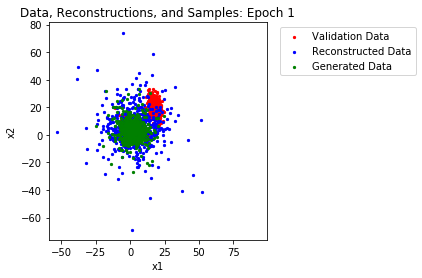

Epoch 2 Average Validation Loss: 9.6066


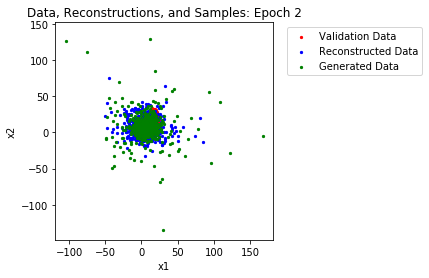

Epoch 3 Average Validation Loss: 9.3853


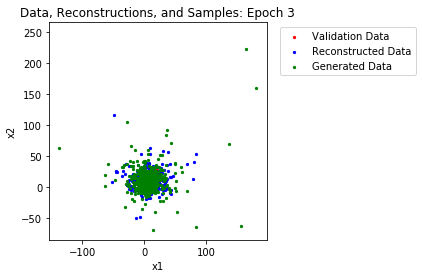

Epoch 4 Average Validation Loss: 9.3489


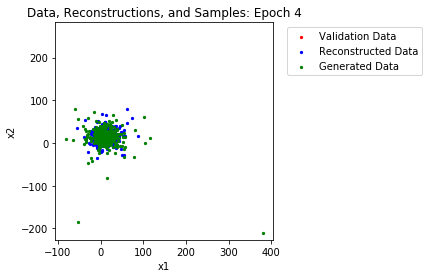

Epoch 5 Average Validation Loss: 9.3281


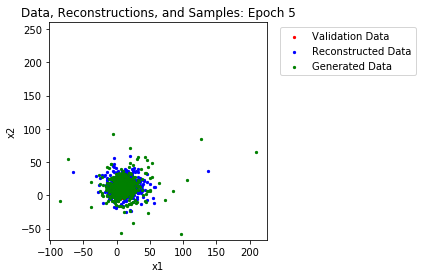

Epoch 6 Average Validation Loss: 9.2420


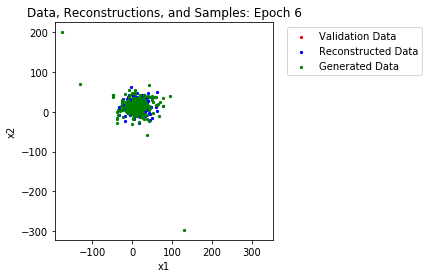

Epoch 7 Average Validation Loss: 9.2124


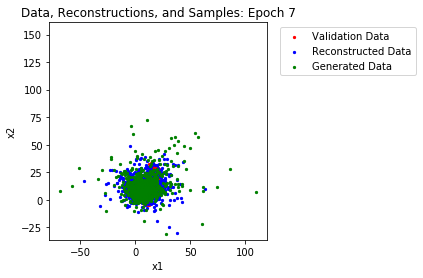

Epoch 8 Average Validation Loss: 9.0574


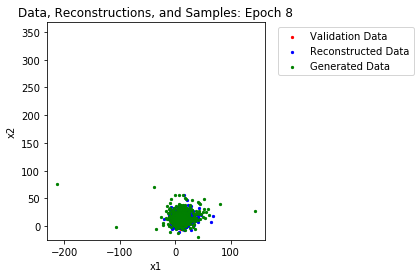

Epoch 9 Average Validation Loss: 8.8254


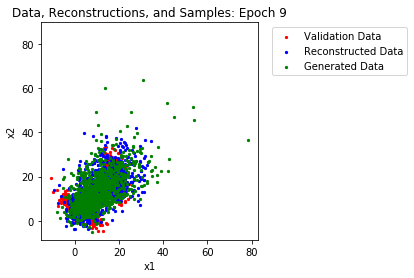

Epoch 10 Average Validation Loss: 8.5154


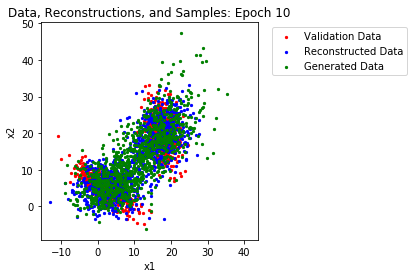

Epoch 11 Average Validation Loss: 8.4353


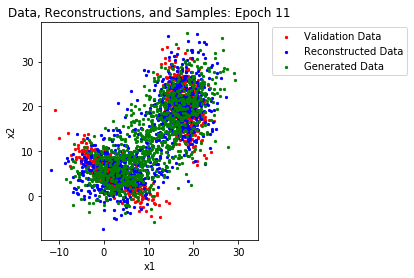

Epoch 12 Average Validation Loss: 8.4057


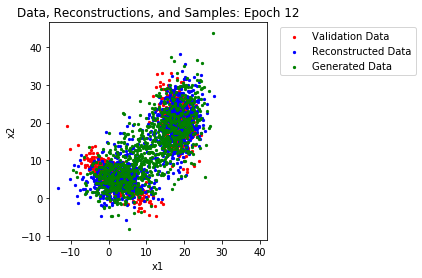

Epoch 13 Average Validation Loss: 8.3194


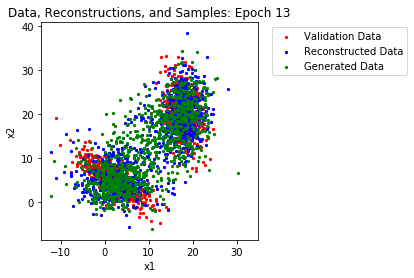

Epoch 14 Average Validation Loss: 8.2771


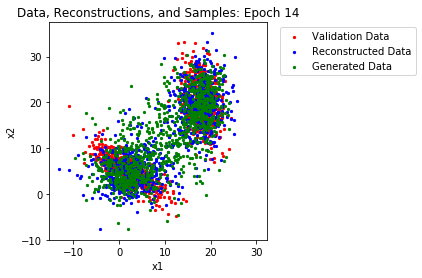

Epoch 15 Average Validation Loss: 8.2345


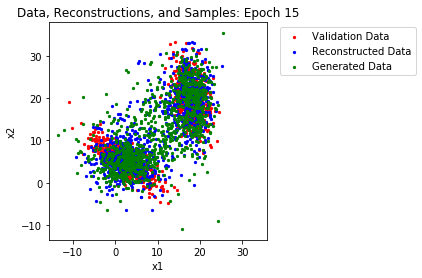

Epoch 16 Average Validation Loss: 8.1924


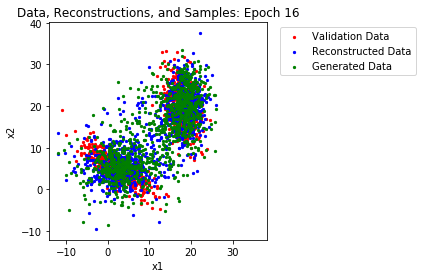

Epoch 17 Average Validation Loss: 8.2737


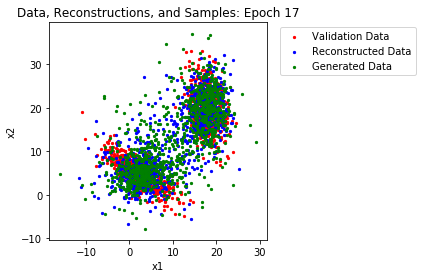

Epoch 18 Average Validation Loss: 8.2314


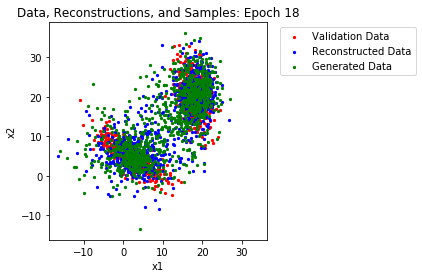

Epoch 19 Average Validation Loss: 8.1831


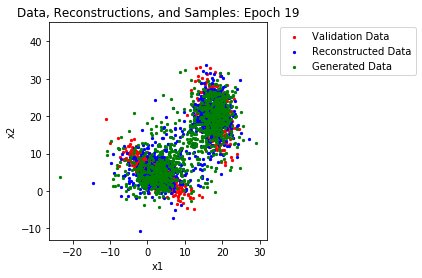

Epoch 20 Average Validation Loss: 8.1765


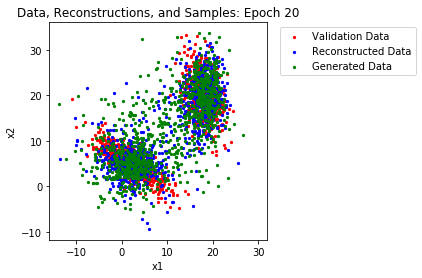

Epoch 21 Average Validation Loss: 8.1409


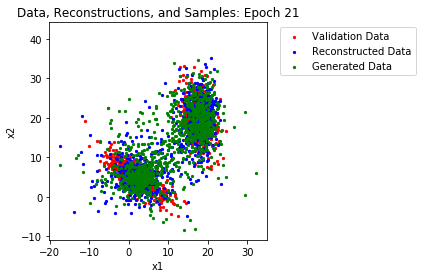

Epoch 22 Average Validation Loss: 8.1305


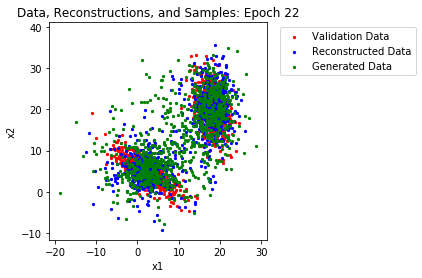

Epoch 23 Average Validation Loss: 8.1217


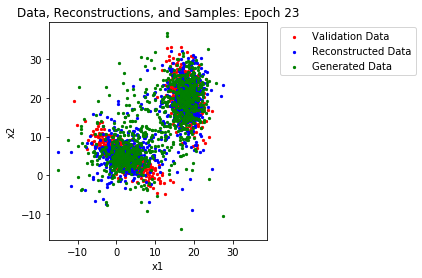

Epoch 24 Average Validation Loss: 8.1418


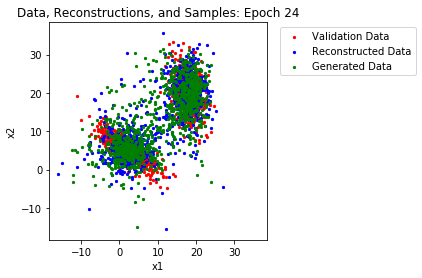

Epoch 25 Average Validation Loss: 8.0988


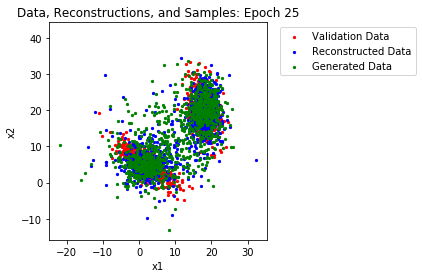

Epoch 26 Average Validation Loss: 8.0928


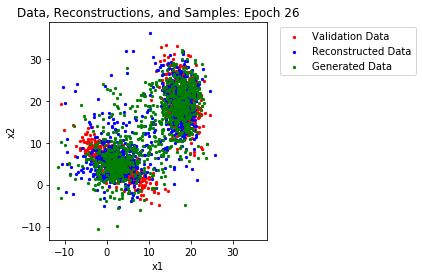

Epoch 27 Average Validation Loss: 8.1017


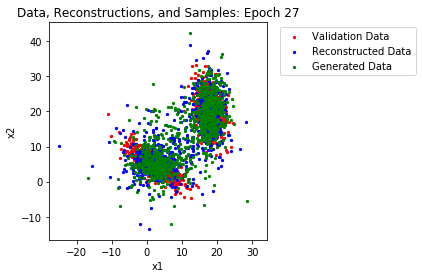

Epoch 28 Average Validation Loss: 8.1261


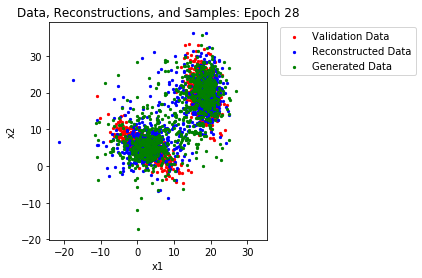

Epoch 29 Average Validation Loss: 8.1289


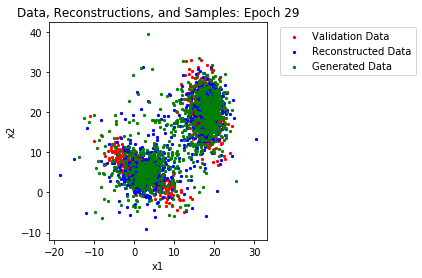

Epoch 30 Average Validation Loss: 8.1570


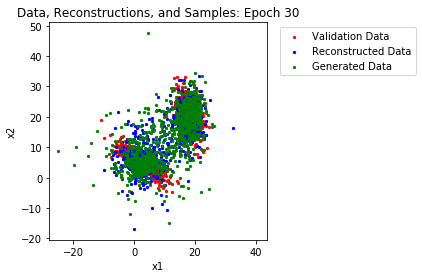

Epoch 31 Average Validation Loss: 8.1182


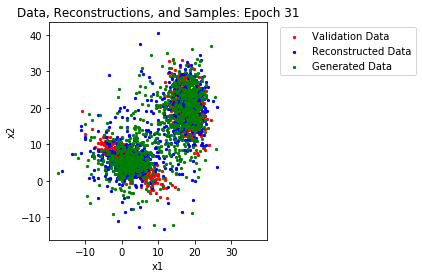

Epoch 32 Average Validation Loss: 8.1178


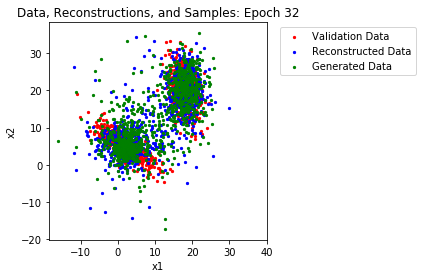

Epoch 33 Average Validation Loss: 8.1063


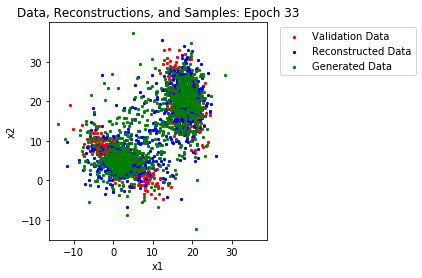

Epoch 34 Average Validation Loss: 8.0926


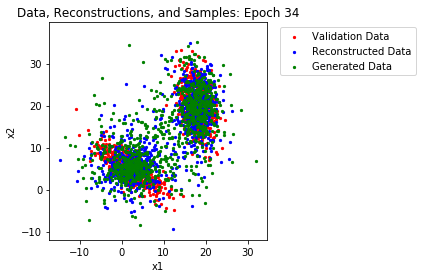

Epoch 35 Average Validation Loss: 8.1495


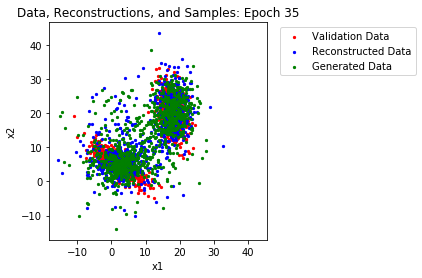

Epoch 36 Average Validation Loss: 8.1437


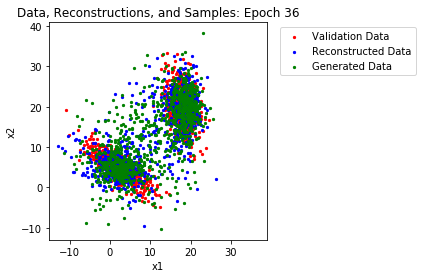

Epoch 37 Average Validation Loss: 8.1519


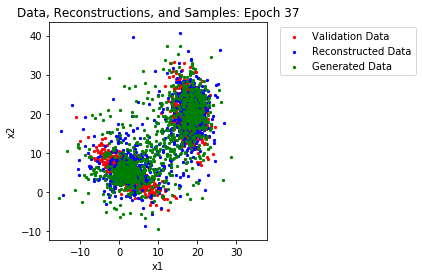

Epoch 38 Average Validation Loss: 8.1666


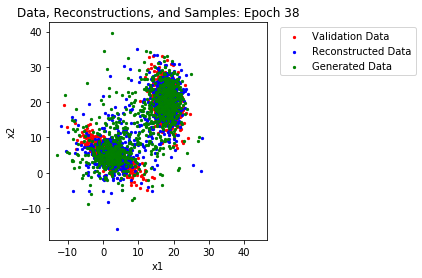

Epoch 39 Average Validation Loss: 8.0888


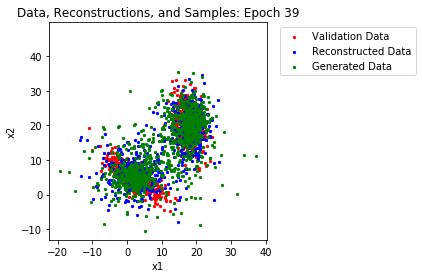

Epoch 40 Average Validation Loss: 8.1293


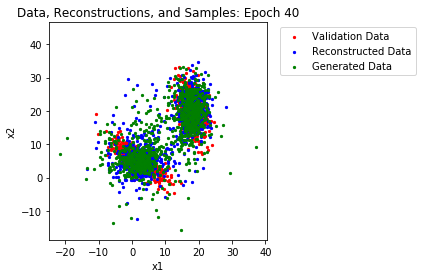

Epoch 41 Average Validation Loss: 8.1475


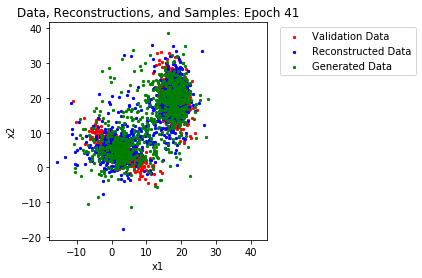

Epoch 42 Average Validation Loss: 8.1407


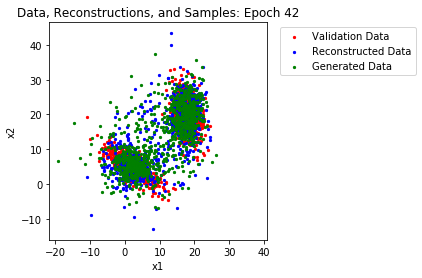

Epoch 43 Average Validation Loss: 8.1044


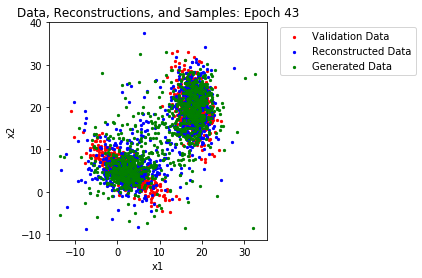

Epoch 44 Average Validation Loss: 8.0920


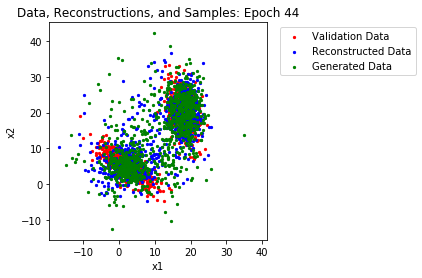

Epoch 45 Average Validation Loss: 8.1253


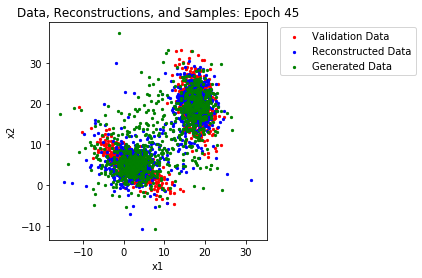

Epoch 46 Average Validation Loss: 8.1463


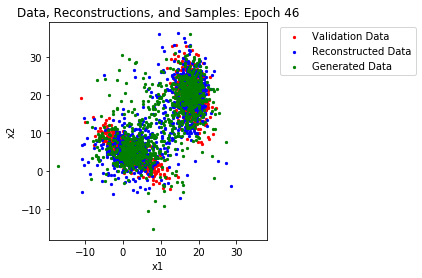

Epoch 47 Average Validation Loss: 8.1763


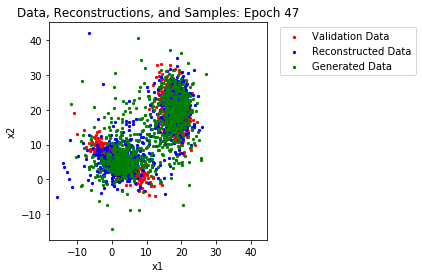

Epoch 48 Average Validation Loss: 8.0953


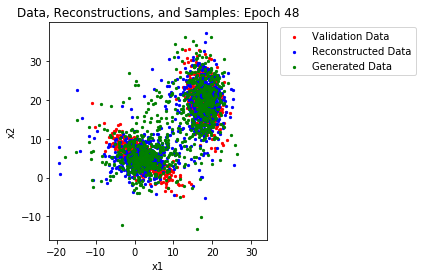

Epoch 49 Average Validation Loss: 8.0336


Epoch 50 Average Validation Loss: 8.1577


Epoch 51 Average Validation Loss: 8.0751


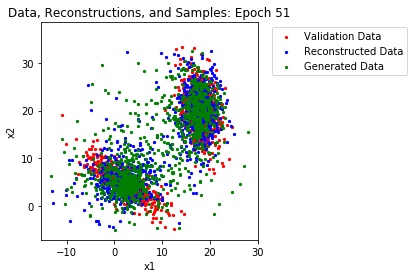

Epoch 52 Average Validation Loss: 8.0918


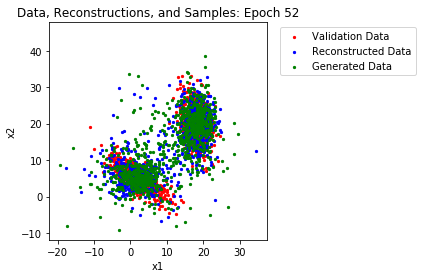

Epoch 53 Average Validation Loss: 8.0845


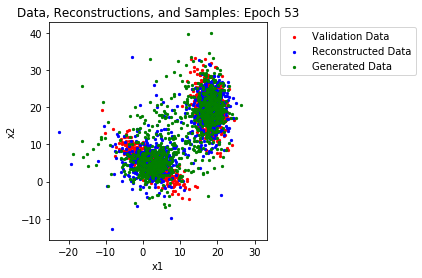

Epoch 54 Average Validation Loss: 8.1144


Epoch 55 Average Validation Loss: 8.0344


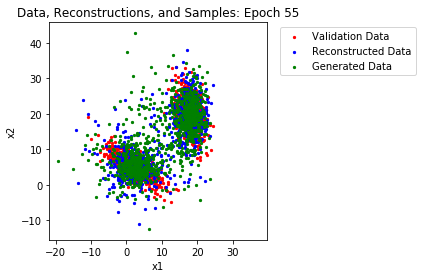

Epoch 56 Average Validation Loss: 8.1127


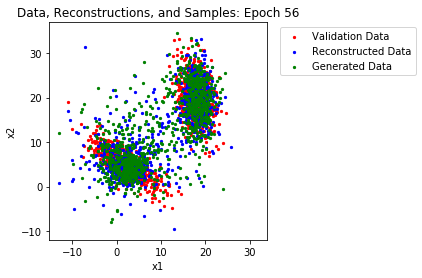

Epoch 57 Average Validation Loss: 8.0631


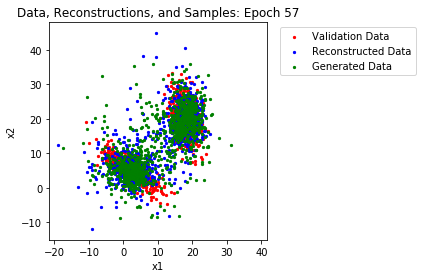

Epoch 58 Average Validation Loss: 8.1242


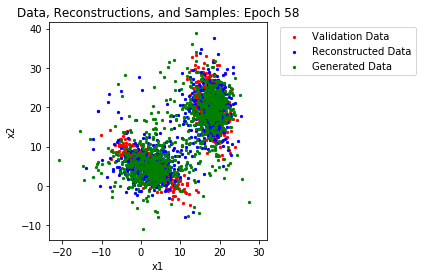

Epoch 59 Average Validation Loss: 8.1551


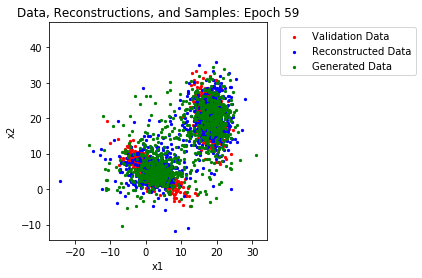

Epoch 60 Average Validation Loss: 8.0528


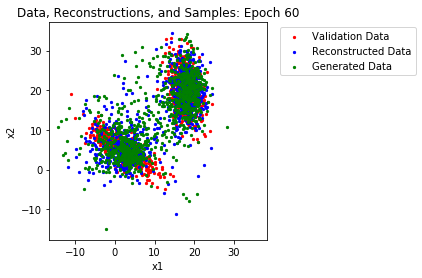

Epoch 61 Average Validation Loss: 8.0525


Epoch 62 Average Validation Loss: 8.1092


Epoch 63 Average Validation Loss: 8.0964


Epoch 64 Average Validation Loss: 8.0516


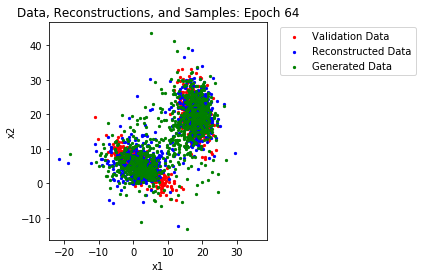

Epoch 65 Average Validation Loss: 8.0451


Epoch 66 Average Validation Loss: 8.0716


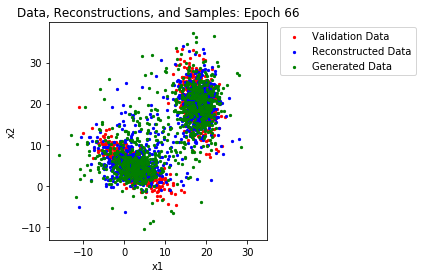

Epoch 67 Average Validation Loss: 8.0298


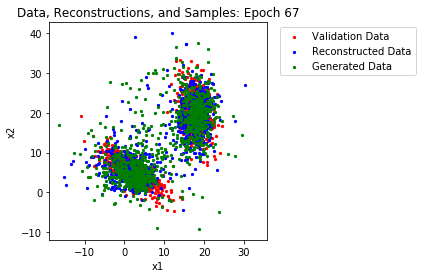

Epoch 68 Average Validation Loss: 8.0976


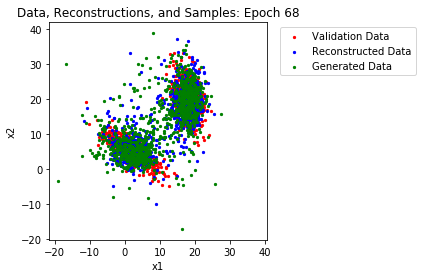

Epoch 69 Average Validation Loss: 8.0853


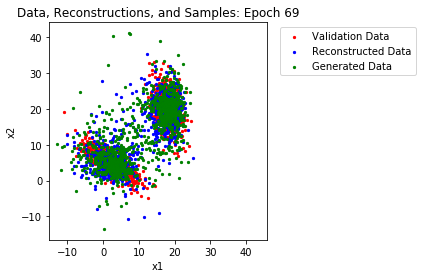

Epoch 70 Average Validation Loss: 8.0684


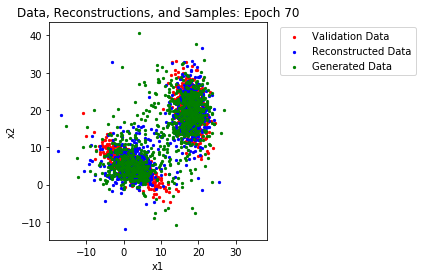

Epoch 71 Average Validation Loss: 8.0674


Epoch 72 Average Validation Loss: 8.0212


Epoch 73 Average Validation Loss: 8.0201


Epoch 74 Average Validation Loss: 8.0221


Epoch 75 Average Validation Loss: 8.0715


Epoch 76 Average Validation Loss: 7.9799


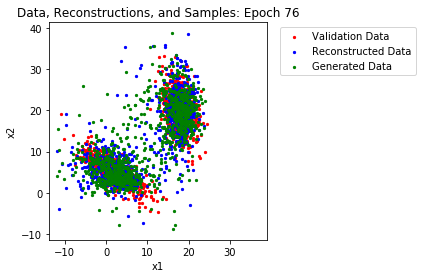

Epoch 77 Average Validation Loss: 8.0117


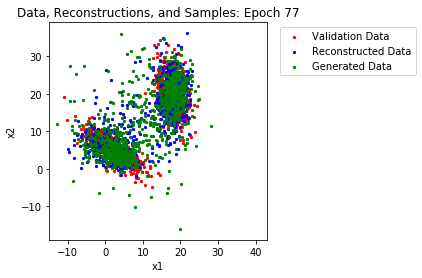

Epoch 78 Average Validation Loss: 8.1065


Epoch 79 Average Validation Loss: 8.0744


Epoch 80 Average Validation Loss: 7.9769


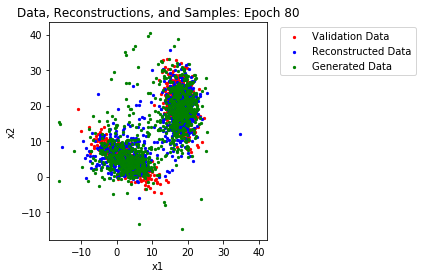

Epoch 81 Average Validation Loss: 8.0340


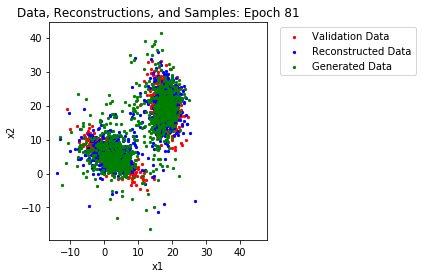

Epoch 82 Average Validation Loss: 8.0998


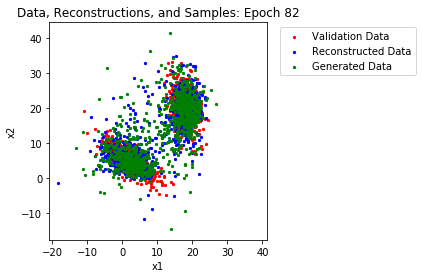

Epoch 83 Average Validation Loss: 8.1676


Epoch 84 Average Validation Loss: 8.0115


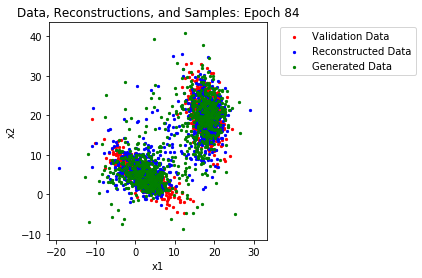

Epoch 85 Average Validation Loss: 8.0166


Epoch 86 Average Validation Loss: 8.0554


Epoch 87 Average Validation Loss: 8.0490


Epoch 88 Average Validation Loss: 8.0000


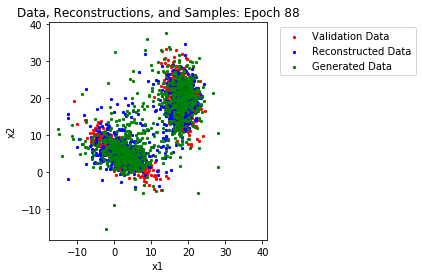

Epoch 89 Average Validation Loss: 8.0496


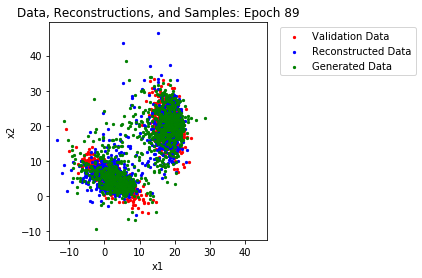

Epoch 90 Average Validation Loss: 8.0228


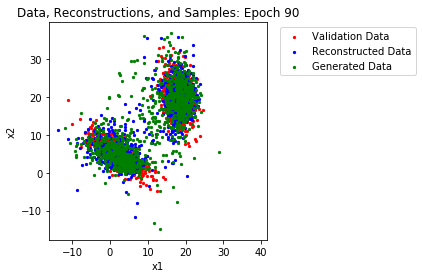

Epoch 91 Average Validation Loss: 8.0539


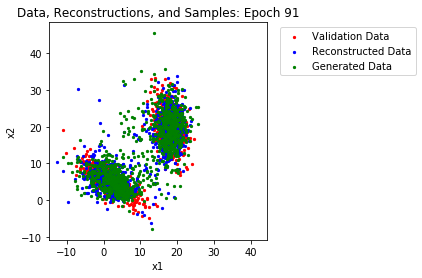

Epoch 92 Average Validation Loss: 7.9459


Epoch 93 Average Validation Loss: 8.0606


Epoch 94 Average Validation Loss: 8.0068


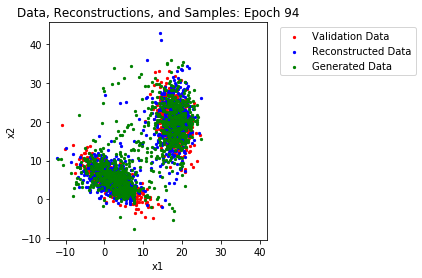

Epoch 95 Average Validation Loss: 7.9890


Epoch 96 Average Validation Loss: 8.0507


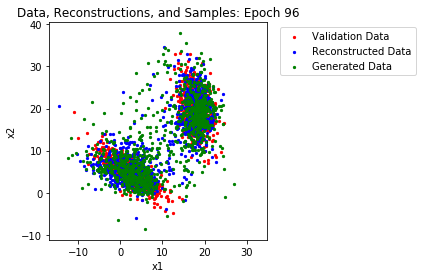

Epoch 97 Average Validation Loss: 7.9869


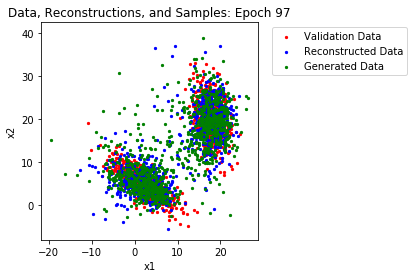

Epoch 98 Average Validation Loss: 7.9887


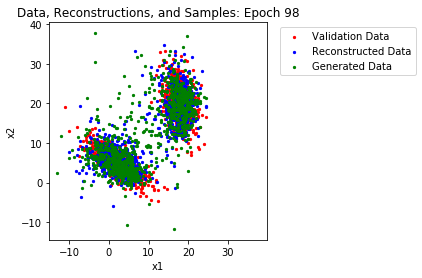

Epoch 99 Average Validation Loss: 7.9927


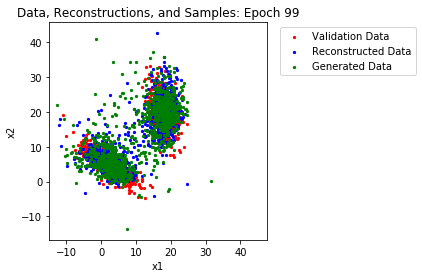

Epoch 100 Average Validation Loss: 7.9636


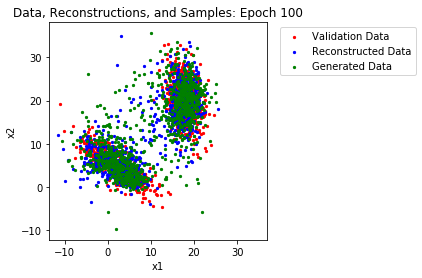

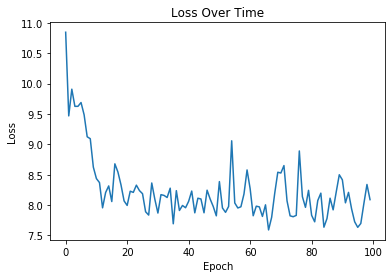

In [64]:
eval(model_list_ex2, loss_list_ex2, valid_loader_ex2, optimizer_ex2)

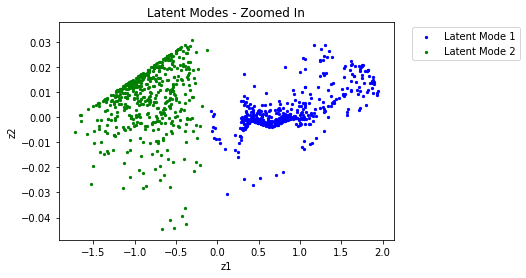

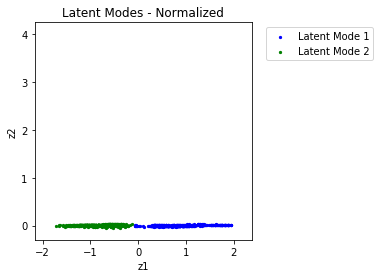

In [65]:
# visualizing the latent space of the final model
final_model_ex2 = model_list_ex2[-1]
latent_data_1 = final_model_ex2._encoder(valid_data_1)  # data from mode 1
latent_data_2 = final_model_ex2._encoder(valid_data_2)  # data from mode 2

# zoomed view
plt.scatter(latent_data_1[:, 0].detach().numpy(), latent_data_1[:, 1].detach().numpy(), c='b', s=5)
plt.scatter(latent_data_2[:, 0].detach().numpy(), latent_data_2[:, 1].detach().numpy(), c='g', s=5)
plt.title("Latent Modes - Zoomed In")
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend(
    ['Latent Mode 1', 'Latent Mode 2'],
    bbox_to_anchor=(1.04,1),
    loc="upper left",
)
plt.show()

# normalized view
plt.scatter(latent_data_1[:, 0].detach().numpy(), latent_data_1[:, 1].detach().numpy(), c='b', s=5)
plt.scatter(latent_data_2[:, 0].detach().numpy(), latent_data_2[:, 1].detach().numpy(), c='g', s=5)
plt.title("Latent Modes - Normalized")
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend(
    ['Latent Mode 1', 'Latent Mode 2'],
    bbox_to_anchor=(1.04,1),
    loc="upper left",
)
ax = plt.gca()
plt.axis('square')
plot_margin = 0.25
x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
plt.show()

## 5. Example 3: MNIST with VAE

### 5.1 Loading Data

The DOWNLOAD_FLAG flag when set to *True* will download the dataset and the necessary file structure into the directory specified by *data_dir*. Once you do this once, you can set it equal to *False* and it will look in root for the data. If you're reading this, there should be the necessary file structure already with the dataset in it. If there isn't, this lets you generate it.

In [8]:
data_dir = './datasets/'
obs_dim = 784  # MNIST contains 28 x 28 images
DOWNLOAD_FLAG = False

# shape of samples is (B, C, L, L), where B is batch, C is channels=1, L is length=28
train_data_mnist = MNIST(
    root=data_dir,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_FLAG,
)
valid_data_mnist = MNIST(
    root=data_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_FLAG,
)

### 5.2 Training Settings

I've set the epochs much higher before than this, but it just takes a very long time to train. I've included a model trained over 50 epochs of data in the ckpts folder, which you can load when generating random samples.

In [35]:
# hyperparameters
latent_dim = 2
batch_size = 32
epochs = 10
lr = 1e-3  # initial learning rate
step_size = 100  # steps per decay for lr scheduler
gamma = 0.95  # multiplicative decay for lr scheduler

In [36]:
# preparing dataloaders, optimizer, and scheduler
model_ex3 = VAE2(latent_dim, obs_dim)
train_loader_ex3 = torch.utils.data.DataLoader(
    train_data_mnist,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
valid_loader_ex3 = torch.utils.data.DataLoader(
    valid_data_mnist,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
optimizer_ex3 = optim.Adam(model_ex3.parameters(), lr=lr)
scheduler_ex3 = optim.lr_scheduler.StepLR(optimizer=optimizer_ex3, step_size=step_size, gamma=gamma)

### 5.3 Training

If you're not tinkering with things specifically, you probably don't want to run the train() block! It takes a lot longer to train a model on data this high-dimensional compared to the extremely low-dimensional data we used before. The first block here just (optionally) selects a model to start training from, useful if you have a checkpoint of a partially trained model. The second block actually trains the model.

In [37]:
# checkpointing
ckpt_path = None  # train from scratch
# ckpt_path = "./ckpts/VAE_MNIST_LOCAL.pth"  # train from saved model

In [38]:
model_list_ex3, loss_list_ex3 = train(
    model_ex3,
    epochs,
    train_loader_ex3,
    optimizer_ex3,
    scheduler=scheduler_ex3,
    vae_type=2,
    print_iter=100,
    ckpt_path=ckpt_path,
)
torch.save(model_list_ex3[-1].state_dict(), './ckpts/VAE_MNIST_LOCAL.pth')

Epoch: 1	Iteration: 100	Loss: 196.6197
Epoch: 1	Iteration: 200	Loss: 200.3084
Epoch: 1	Iteration: 300	Loss: 163.8946
Epoch: 1	Iteration: 400	Loss: 172.5596
Epoch: 1	Iteration: 500	Loss: 166.3033
Epoch: 1	Iteration: 600	Loss: 174.9170
Epoch: 1	Iteration: 700	Loss: 159.7830
Epoch: 1	Iteration: 800	Loss: 173.6197
Epoch: 1	Iteration: 900	Loss: 179.9393
Epoch: 1	Iteration: 1000	Loss: 159.3957
Epoch: 1	Iteration: 1100	Loss: 167.7457
Epoch: 1	Iteration: 1200	Loss: 173.2477
Epoch: 1	Iteration: 1300	Loss: 162.1042
Epoch: 1	Iteration: 1400	Loss: 158.1158
Epoch: 1	Iteration: 1500	Loss: 169.5764
Epoch: 1	Iteration: 1600	Loss: 165.2652
Epoch: 1	Iteration: 1700	Loss: 156.1889
Epoch: 1	Iteration: 1800	Loss: 168.8092
Epoch: 2	Iteration: 1900	Loss: 150.9475
Epoch: 2	Iteration: 2000	Loss: 142.8605
Epoch: 2	Iteration: 2100	Loss: 158.7757
Epoch: 2	Iteration: 2200	Loss: 144.5686
Epoch: 2	Iteration: 2300	Loss: 158.2393
Epoch: 2	Iteration: 2400	Loss: 157.9126
Epoch: 2	Iteration: 2500	Loss: 151.9883
Epoch: 2	

### 5.4 Evaluation

Since the data are 784-dimensional, we can't just plot them to visualize the distribution. However, we can just draw samples from the model at each stage in training to see if it outputs stuff that looks reasonably like images of digits. 

Run the first block to reconstruct the first sample from the validation set at each epoch and also to generate a random sample. You can only run this right after the train() function is called or you won't have the model lists. However, you can still use the generation code below to write something to test reconstruction on the cached model.

Run the second block to sample a random image from the final model. You can run this as many times as you want to generate samples. Observe that every time you run it, a different number will appear. This is because you can't control the conditioning of the sample. Again, CVAEs address this problem.

Run the third block to visualize the latent manifold. To generate this, we sweep through latent values from -3 to 3 on each axis and then pass that through the decoder to see what is generated. Recall that for our specific model, this mapping is deterministic. Code adapted from: https://github.com/ykwon0407/variational_autoencoder/blob/master/variational_bayes.ipynb

Epoch 1 Average Validation Loss: 162.1169
Epoch 2 Average Validation Loss: 155.3288
Epoch 3 Average Validation Loss: 152.3197
Epoch 4 Average Validation Loss: 150.5476
Epoch 5 Average Validation Loss: 148.3428
Epoch 6 Average Validation Loss: 147.4445
Epoch 7 Average Validation Loss: 145.8412
Epoch 8 Average Validation Loss: 145.6305
Epoch 9 Average Validation Loss: 144.7326
Epoch 10 Average Validation Loss: 145.2119


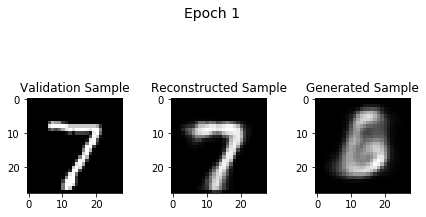

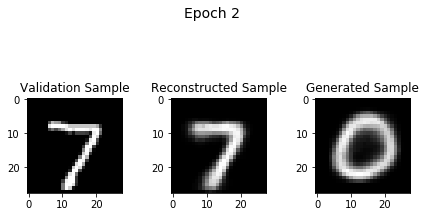

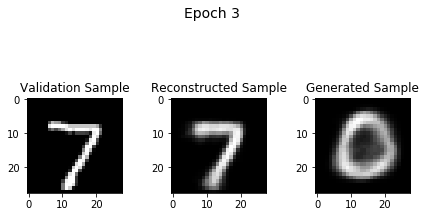

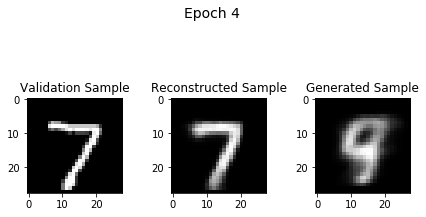

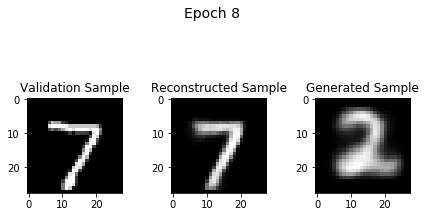

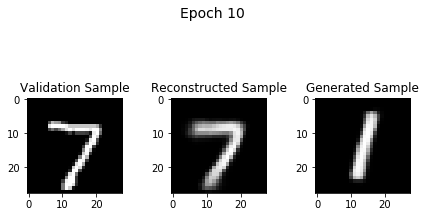

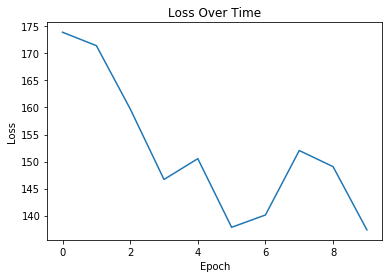

In [39]:
eval(model_list_ex3, loss_list_ex3, valid_loader_ex3, optimizer_ex3, vae_type=2)

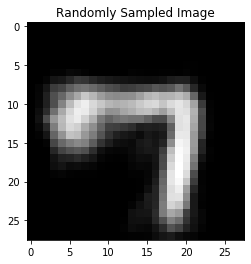

In [70]:
# generate random samples of handwritten numbers
final_model_ex3 = VAE2(2, 784)
final_model_ex3.load_state_dict(torch.load('./ckpts/VAE_MNIST.pth'))  # provided model
img_sample = final_model_ex3.generate(1)
plt.imshow(img_sample.detach(), cmap='gray')
plt.title('Randomly Sampled Image')
plt.show()

In [46]:
# loading model
final_model_ex3 = VAE2(2, 784)
final_model_ex3.load_state_dict(torch.load('./ckpts/VAE_MNIST.pth'))  # provided model

# initializing latent manifold
num_points = 20
z1_vals = np.linspace(-3, 3, num_points)
z2_vals = np.linspace(-3, 3, num_points)
manifold = np.empty((28 * num_points, 28 * num_points))

# looping through latent values to fill manifold
for i, z1i in enumerate(z1_vals):
    for j, z2j in enumerate(z2_vals):
        z = torch.Tensor([z1i, z2j])
        x_gen_flat = final_model_ex3._decoder(z)
        x_gen = x_gen_flat.reshape(28, 28)
        manifold[
            ((num_points - i - 1) * 28) : ((num_points - i) * 28),
            (j * 28):((j + 1) * 28)
        ] = x_gen.detach()

# plotting
plt.figure(figsize=(12, 12))
plt.imshow(manifold, cmap='gray')
plt.tight_layout()